#  Analyze EGFD Accountability Data 

E.Quinn  7/28/2018

In [1]:
import re
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import struct
from datetime import datetime
import datetime

In [2]:
pd.set_option('display.max_rows', 3000)

In [3]:
start_date = datetime.datetime(2017,5,31,23,0,0)
end_date   = datetime.datetime(2018,5,17,1,0,0)

## Dictionary for looking up platoon by name

In [4]:
FF_platoon = {'FF Andrade': 'C','FF Archambault': 'A','Lt Babcock': 'D','Lt Bailey': 'A','Lt Beaudreau': 'B','FF Campbell': 'A', \
         'FF Columbier': 'B','Prob-FF Crute': 'B','FF DeLuca': 'A','FF Forte': 'C','Lt Gardner': 'B','Prob-FF Gorman': 'D', \
         'Lt Grady': 'B','Lt Greene': 'B','Lt Hall': 'D','FF Howard': 'B','Lt Jones': 'C','FF King': 'C','FF Lang Jr.': 'D', \
         'Prob-FF Lavallee': 'D','FF Marsh': 'D','Lt Matola, Jr.': 'D','FF McKeon': 'C','Capt Mears': 'C','Lt Monaghan': 'A', \
         'Capt Montville': 'A',"FF O'Donnell": 'A','Prob-FF Perry': 'B','Lt Perry': 'B','Prob-FF Preston': 'A',  \
         'Lt Purcell': 'C','Lt Richardson': 'A','FF Snowling': 'B','FF Stabile': 'D','FF Szerlag': 'C','Lt Warner III': 'D'}                 


## Dictionary for looking up identifier by name

In [5]:
FF_token = {'FF Andrade': 'CFF2','FF Archambault': 'AFF1','Lt Babcock': 'DOF2','Lt Bailey': 'AOF2', \
        'Lt Beaudreau': 'BOF3','FF Campbell': 'AFF4', \
        'FF Columbier': 'BFF1','Prob-FF Crute': 'BFF4','FF DeLuca': 'AFF5','FF Forte': 'CFF4', \
        'Lt Gardner': 'BOF2','Prob-FF Gorman': 'DFF5', \
        'Lt Grady': 'BOF4','Lt Greene': 'COF4','Lt Hall': 'DOF1','FF Howard': 'BFF3','Lt Jones': 'COF2', \
        'FF King': 'CFF1','FF Lang Jr.': 'DFF3', \
        'Prob-FF Lavallee': 'DFF4','FF Marsh': 'DFF1','Lt Matola, Jr.': 'DOF4','FF McKeon': 'CFF5', \
        'Capt Mears': 'COF1','Lt Monaghan': 'AOF4', \
        'Capt Montville': 'AOF3',"FF O'Donnell": 'AFF2','Prob-FF Perry': 'BFF5','Lt Perry': 'BOF1', \
        'Prob-FF Preston': 'AFF3', 'Lt Purcell': 'COF3','Lt Richardson': 'AOF1','FF Snowling': 'BFF2', \
        'FF Stabile': 'DFF2','FF Szerlag': 'CFF3','Lt Warner III': 'DOF3','FF Squillante':'EFF1'}                 


## Dictionary for looking up name by identifier

In [6]:
token_FF = {'CFF2':'FF Andrade','AFF1':'FF Archambault','DOF2':'Lt Babcock','AOF2':'Lt Bailey', \
        'BOF3':'Lt Beaudreau','AFF4':'FF Campbell', \
        'BFF1':'FF Columbier','BFF4':'Prob-FF Crute','AFF5':'FF DeLuca','CFF4':'FF Forte', \
        'BOF2':'Lt Gardner','DFF5':'Prob-FF Gorman', \
        'BOF4':'Lt Grady','COF4':'Lt Greene','DOF1':'Lt Hall','BFF3':'FF Howard','COF2':'Lt Jones', \
        'CFF1':'FF King','DFF3':'FF Lang Jr.', \
        'DFF4':'Prob-FF Lavallee','DFF1':'FF Marsh','DOF4':'Lt Matola, Jr.','CFF5':'FF McKeon', \
        'COF1':'Capt Mears','AOF4':'Lt Monaghan', \
        'AOF3':'Capt Montville','AFF2':"FF O'Donnell",'BFF5':'Prob-FF Perry','BOF1':'Lt Perry', \
        'AFF3':'Prob-FF Preston', 'COF3':'Lt Purcell','AOF1':'Lt Richardson','BFF2':'FF Snowling', \
        'DFF2':'FF Stabile','CFF3':'FF Szerlag','DOF3':'Lt Warner III','EFF1':'FF Squillante'}                 


## Dictionary of 8-day cycle start times by platoon

Get cycle start times that fall between start_date and end_date

In [7]:
base_date = {}
base_date['A'] = datetime.datetime(2016,12,26,7,0,0)   #first cycle start 1/1/2017 07:00 or earlier for this platoon
base_date['B'] = datetime.datetime(2016,12,28,7,0,0)
base_date['C'] = datetime.datetime(2016,12,30,7,0,0)
base_date['D'] = datetime.datetime(2017,1,1,7,0,0)

cycle_start = {}                                       # dictionary for cycle start by platoon

max_datetime = datetime.datetime(2018,7,1,0,0,0)

for platoon in base_date.keys():                      # loop through earliest cycle start for each platoon
    cycle_start[platoon] = {}                         # create dictionary for platoon
    ss = base_date[platoon]                           # start with earliest cycle start time
    while (ss < max_datetime):                         # loop until cycle start is past max_datetime
        if ((ss > start_date) & (ss < end_date)):
            cycle_start[platoon][ss] = {}                 # add dictionary for cycle start
        ss += datetime.timedelta(days=8)               # increment cycle start by 8 days

cycle_start

print('Number of 8-Day Cycles')
print('A ' + str(len(cycle_start['A'])))
print('B ' + str(len(cycle_start['B'])))
print('C ' + str(len(cycle_start['C'])))
print('D ' + str(len(cycle_start['D'])))

Number of 8-Day Cycles
A 44
B 44
C 43
D 44


## Build list of shifts for each FF

In [8]:
shifts = {}       

for platoon in ['A','B','C','D']:
    for ffn in ['OF1','OF2','OF3','OF4','FF1','FF2','FF3','FF4','FF5']:
        token = platoon+ ffn
        shifts[token] = {}
        shifts[token]['name'] = token_FF[token]
        shifts[token]['platoon'] = platoon
        shifts[token]['shifts'] = {}
        for cycle in cycle_start[platoon]:
            shift = cycle
            shifts[token]['shifts'][shift] = {'type':'scheduled'}
            shift += datetime.timedelta(days=1)   # increment cycle start by 10 hours + 1 day
            shifts[token]['shifts'][shift] = {'type':'scheduled'}
            shift += datetime.timedelta(days=1)
            shift += datetime.timedelta(hours=10)   # increment cycle start by 10 hours + 1 day
            shifts[token]['shifts'][shift] = {'type':'scheduled'}
            shift += datetime.timedelta(days=1)   # increment cycle start by 1 day
            shifts[token]['shifts'][shift] = {'type':'scheduled'}
        

In [9]:
shifts

{'AOF1': {'name': 'Lt Richardson',
  'platoon': 'A',
  'shifts': {datetime.datetime(2017, 6, 4, 7, 0): {'type': 'scheduled'},
   datetime.datetime(2017, 6, 5, 7, 0): {'type': 'scheduled'},
   datetime.datetime(2017, 6, 6, 17, 0): {'type': 'scheduled'},
   datetime.datetime(2017, 6, 7, 17, 0): {'type': 'scheduled'},
   datetime.datetime(2017, 6, 12, 7, 0): {'type': 'scheduled'},
   datetime.datetime(2017, 6, 13, 7, 0): {'type': 'scheduled'},
   datetime.datetime(2017, 6, 14, 17, 0): {'type': 'scheduled'},
   datetime.datetime(2017, 6, 15, 17, 0): {'type': 'scheduled'},
   datetime.datetime(2017, 6, 20, 7, 0): {'type': 'scheduled'},
   datetime.datetime(2017, 6, 21, 7, 0): {'type': 'scheduled'},
   datetime.datetime(2017, 6, 22, 17, 0): {'type': 'scheduled'},
   datetime.datetime(2017, 6, 23, 17, 0): {'type': 'scheduled'},
   datetime.datetime(2017, 6, 28, 7, 0): {'type': 'scheduled'},
   datetime.datetime(2017, 6, 29, 7, 0): {'type': 'scheduled'},
   datetime.datetime(2017, 6, 30, 17, 0

## Lookup dictionary to get accountability file names by FF

These are the .csv files extracted from Eric's spreadsheet of accountability data

In [10]:
logs = {'FF Andrade': 'FF_Andrade.csv', \
                       'FF Archambault': 'FF_Archambault.csv', \
                       'Lt Babcock': 'Lt_Babcock.csv', \
                       'Lt Bailey': 'Lt_Bailey.csv', \
                       'Lt Beaudreau': 'Lt_Beaudreau.csv', \
                       'FF Campbell': 'FF_Campbell.csv', \
                       'FF Columbier': 'FF_Columbier.csv', \
                       'Prob-FF Crute': 'Prob-FF_Crute.csv', \
                       'FF DeLuca': 'FF_DeLuca.csv', \
                       'FF Forte': 'FF_Forte.csv', \
                       'Lt Gardner': 'Lt_Gardner.csv', \
                       'Prob-FF Gorman': 'Prob-FF_Gorman.csv', \
                       'Lt Grady': 'Lt_Grady.csv', \
                       'Lt Greene': 'Lt_Greene.csv', \
                       'Lt Hall': 'FF_Hall.csv', \
                       'FF Howard': 'FF_Howard.csv', \
                       'Lt Jones': 'Lt_Jones.csv', \
                       'FF King': 'FF_King.csv',
                       'FF Lang Jr.': 'FF_Lang.csv', \
                       'Prob-FF Lavallee': 'Prob-FF_Lavallee.csv', \
                       'FF Marsh': 'FF_Marsh.csv', \
                       'Lt Matola, Jr.': 'Lt_Matola.csv', \
                       'FF McKeon': 'FF_McKeon.csv', \
                       'Capt Mears': 'Capt_Mears.csv', \
                       'Lt Monaghan': 'Lt_Monaghan.csv', \
                       'Capt Montville': 'Capt_Montville.csv', \
                       "FF O'Donnell": 'FF_ODonnell.csv', \
                       'Prob-FF Perry': 'Prob-FF_Perry.csv', \
                       'Lt Perry': 'Lt_Perry.csv', \
                       'Prob-FF Preston': 'Prob-FF_Preston.csv',  \
                       'Lt Purcell': 'Lt_Purcell.csv', \
                       'Lt Richardson': 'Lt_Richardson.csv', \
                       'FF Snowling': 'FF_Snowling.csv', \
                       'FF Stabile': 'FF_Stabile.csv', \
                       'FF Szerlag': 'FF_Szerlag.csv', \
                       'Lt Warner III': 'Lt_Warner.csv'}                 

## Read the accountability logs and add the data to the dictionaries

There is one .csv file containing the accountability data for each firefighter

Data elements are added to the dictionary for that firefighter and shift

In [11]:
def findOccurrences(s, ch):
    return [i for i, letter in enumerate(s) if letter == ch]

In [12]:
def clean_reason(reason,for_ff):
    new_reason = ''
    if (for_ff == ''):
        new_reason += reason
    else:
        if ((',' in reason) & ('-' in reason)):
            ix = findOccurrences(reason,'-')
            ix_last = ix[len(ix)-1]
            new_reason += FF_token[for_ff] + reason[ix_last:]

    return(new_reason)        

In [13]:
def read_acct(token):
    
    ff_name = token_FF[token]
    fname = '../' + logs[ff_name]                                   #get the filename for this FF
    acctdf = pd.read_csv(fname,parse_dates=[[0,1]],skiprows=2,header=None)   #read it
    acctdf.rename(columns={'0_1': 'shift',2:'type',3:'hours',4:'rank',5:'reason'},inplace=True)
    acctdf['FF_name'] = ff_name       #create a column for this FFs name
    
    for index, row in acctdf.iterrows():    #loop through row by row and add data to dictionary
        ff_name = row['FF_name']             #shifts dictionary key is FF name
        shift = row['shift'].to_pydatetime()
        dtv = datetime.datetime(shift.year,shift.month,shift.day,shift.hour,0,0)
        if dtv not in shifts[token]['shifts']:
            shifts[token]['shifts'][dtv] = {}
        
        try:                                      #create dictionary for accountability data
            sdict = shifts[token]['shifts'][dtv]['acct']
        except KeyError:                          #if this shift was not found add it
            shifts[token]['shifts'][dtv]['acct'] = {}
            sdict = shifts[token]['shifts'][dtv]['acct']
                                                  #fill in the accountability data elements
        typ = row['type']
        sdict['type'] = row['type']
        sdict['hours'] = float(row['hours'])
        sdict['rank'] = row['rank']
        sdict['reason'] = row['reason']
        rstr = row['reason']                      #determine whose shift was being covered
        for_ff = ''                               #search for specific name in reason string
        if isinstance(rstr, str):
            if ('Andrade' in rstr):  for_ff = 'FF Andrade'
            if ('Archambault' in rstr):  for_ff = 'FF Archambault'
            if ('Babcock' in rstr):  for_ff = 'Lt Babcock'
            if ('Bailey' in rstr): for_ff = 'Lt Bailey'
            if ('Beaudreau' in rstr): for_ff = 'Lt Beaudreau'
            if ('Campbell' in rstr): for_ff = 'FF Campbell'
            if ('Columbier' in rstr): for_ff = 'FF Columbier'
            if ('Crute' in rstr): for_ff = 'Prob-FF Crute'
            if ('DeLuca' in rstr): for_ff = 'FF DeLuca'
            if ('Forte' in rstr): for_ff = 'FF Forte'
            if ('Gardner' in rstr): for_ff = 'Lt Gardner'
            if ('Gorman' in rstr): for_ff = 'Prob-FF Gorman'
            if ('Grady' in rstr): for_ff = 'Lt Grady'
            if ('Greene' in rstr): for_ff = 'Lt Greene'
            if ('Hall' in rstr): for_ff = 'Lt Hall'
            if ('Howard' in rstr): for_ff = 'FF Howard'
            if ('Jones' in rstr): for_ff = 'Lt Jones'
            if ('King' in rstr): for_ff = 'FF King'
            if ('Lang' in rstr): for_ff = 'FF Lang Jr.'
            if ('Lavallee' in rstr): for_ff = 'Prob-FF Lavallee'
            if ('Marsh' in rstr): for_ff = 'FF Marsh'
            if ('Matola' in rstr): for_ff = 'Lt Matola, Jr.'
            if ('McKeon' in rstr): for_ff = 'FF McKeon'
            if ('Mears' in rstr): for_ff = 'Capt Mears'
            if ('Monaghan' in rstr): for_ff = 'Lt Monaghan'
            if ('Montville' in rstr): for_ff = 'Capt Montville'
            if ('Donnell' in rstr): for_ff = "FF O'Donnell"
            if ('FF Perry' in rstr): for_ff = 'Prob-FF Perry'
            if ('Lt Perry' in rstr): for_ff = 'Lt Perry'
            if ('Preston' in rstr): for_ff = 'Prob-FF Preston'
            if ('Purcell' in rstr): for_ff = 'Lt Purcell'
            if ('Richardson' in rstr): for_ff = 'Lt Richardson'
            if ('Snowling' in rstr): for_ff = 'FF Snowling'
            if ('Squillante' in rstr): for_ff = 'FF Squillante'
            if ('Stabile' in rstr): for_ff = 'FF Stabile'
            if ('Szerlag' in rstr): for_ff = 'FF Szerlag'
            if ('Warner' in rstr): for_ff = 'Lt Warner III'
            if (len(for_ff) > 0):
                shifts[token]['shifts'][dtv]['acct']['for_token'] = FF_token[for_ff]    #save FF being covered
            else:
                shifts[token]['shifts'][dtv]['acct']['for_token'] = ''  #no for_ff
            shifts[token]['shifts'][dtv]['acct']['clean_reason'] = clean_reason(rstr,for_ff)
    return()

In [14]:
for token in shifts.keys():
    read_acct(token)

## Write web page displaying results

## Set cell background color

In [15]:
def cellcolor(token,ts,shifts):
    bgcolor = '#FFFFFF'
    try:
        typ = shifts[token]['shifts'][ts]['acct']['type']
        if (typ == 'VC'): bgcolor = '#C0C0C0'
        if (typ == 'IOD'): bgcolor = '#FF00FF'
        if (typ in ['PRS','BER']): bgcolor = '#FFFF00'
        if ('CS-' in typ): bgcolor = '#00FF00'
        if ('C-' in typ): bgcolor = '#00FF00'
    except KeyError:
        x=1
    return(bgcolor)

## Build type tag as a link into accountability data

In [16]:
def line2(token,ts,shifts):
    l2str = '<br>'
    try:
        typ = shifts[token]['shifts'][ts]['acct']['type']
        tag = token + str(ts)
        if (typ in ['VC','IOD','SWAP','SWAPW','SL','PRS','BER']): 
            l2str += '<a href="#' + tag + '">' + typ + '</a>'
        if ('OT-' in typ): l2str += '<a href="#' + tag + '">' + typ + '</a>'
        if (('C-' in typ) | ('CS-' in typ)): l2str += '<a href="#' + tag + '">' + typ + '</a>'
    except KeyError:
        ;
    return(l2str)

## Build line 3: FF being covered, or FF covering

In [17]:
def line3(token,ts,shifts):
    l3str = '<br>'
    
    try:
        if (shifts[token]['shifts'][ts]['acct']['for_token'] != ''):
            token2 = shifts[token]['shifts'][ts]['acct']['for_token']
            tag = token2 + str(ts)
            l3str += '<a href="#' + tag + '">' + token2 + '</a>'
        else:
            for token2 in shifts.keys():
                try:
                    if (shifts[token2]['shifts'][ts]['acct']['for_token'] == token):
                        tag = token2 + str(ts)
                        l3str += '<a href="#' + tag + '">' + token2 + '</a>'
                except KeyError:
                    ;

    except KeyError:
            ;
    return(l3str)

## Build a row of cells representing a shift

In [18]:
def shiftabl(token,year,month,hour,shifts,file):        
    ndays = {1:31,2:28,3:31,4:30,5:31,6:30,7:31,8:31,9:30,10:31,11:30,12:31}
    if (hour == 7): 
        full_shift=10
        rowstr = '<tr align="center"><td rowspan="2">' + str(month) + '/' + str(year) + '</td>'
        rowstr +='<td>07:00</td>'
    else: 
        full_shift=14
        rowstr = '<tr><td>17:00</td>'
    
    for d in range(1,1+ndays[month]):
        ts = datetime.datetime(year,month,d,hour,0,0)
        tag = token + str(ts)
        
        rowstr += '<td bgcolor="' + cellcolor(token,ts,shifts) + '">'
        
                                                        #see if we are scheduled this shift
        try:
            if (shifts[token]['shifts'][ts]['type']=='scheduled'):   #see if there is an entry for this timestamp
                rowstr += 'On'
        except KeyError:
            rowstr += '&nbsp;'
        rowstr += line2(token,ts,shifts)
        rowstr += line3(token,ts,shifts)
        rowstr += '</td>'
    file.write(rowstr + '</tr>\n')
    return()

In [19]:
def scheduled_this_cycle(cs):            #returns the four shifts scheduled in this cycle
    
    ts_list = []
    ts = cs
    ts_list.append(ts)
    ts += datetime.timedelta(days=1)
    ts_list.append(ts)
    ts += datetime.timedelta(days=1)
    ts += datetime.timedelta(hours=10)   # increment cycle start by 10 hours + 1 day
    ts_list.append(ts)
    ts += datetime.timedelta(days=1)
    ts_list.append(ts)
    return(ts_list)

In [20]:
def this_cycle(cs):            #returns the 16 shifts scheduled in this 8-day cycle
    
    cy_list = []
    ts = cs
    for hrs in [0,10,14,10,14,10,14,10,14,10,14,10,14,10,14,10]:
        ts += datetime.timedelta(hours=hrs)
        cy_list.append(ts)
    print(cy_list)
    return(cy_list)

In [21]:
def shift_hours(token,ts,shifts):            #returns a dictionary with all hours for this cycle
    
    sh = {}
    
    try:
        this_ff = shifts[token]['shifts'][ts]   #see if they have a record for this shift
        if ('acct' in this_ff.keys()):
            typ = this_ff['acct']['type']
            sh[typ] = this_ff['acct']['hours']
        if ('type' in this_ff.keys()):
            typ = this_ff['type']
            if (ts.hour == 7): sh[typ] = 10.0
            if (ts.hour == 17): sh[typ] = 14.0
    except KeyError:
            ;
    return(sh)
            

In [22]:
def full_shift(ts):
    if (ts.hour == 7): hours = 10.0
    if (ts.hour == 17): hours = 14.0
    return(hours)

In [23]:
def disp_val(typ,dct):
    disp_val = '&nbsp'
    if (typ in dct.keys()):
        if (dct[typ] > 0.0): disp_val = str(dct[typ])
    return(disp_val)

In [24]:
def add_hours(dct,key,x):
    if (key in dct.keys()):
        dct[key] += x
    else:
        dct[key] = x
    return()

In [25]:
def add_cumulative_hours(dct,totdct):
    for key in dct.keys():
        if (key in totdct.keys()):
            totdct[key] += dct[key]
        else:
            totdct[key] = dct[key]
    return()

## Build the detail web page

In [26]:
file = open('../detail.html','w') 

file.write('<html><body>') 

for token in shifts.keys():
    ff_name = token_FF[token]
    file.write('<a name="' + ff_name + '">')
    file.write('<h2>' + token + ' ' + '</h2></a>\n')
    file.write('<table border="1">\n')
    
    file.write('<tr><td>Month</td><td>Shift</td>')
    for d in range(1,32):
        file.write('<td>' + str(d) + '</td>')
    file.write('</tr>\n')
    
    year = 2017
    month = 1
    
    for i in range(1,18):
            
        shiftabl(token,year,month,7,shifts,file)  
        shiftabl(token,year,month,17,shifts,file) 
        
        month += 1
        if (month > 12):
            year += 1
            month = 1
        
    file.write('</table>\n')
    
for token in shifts.keys():
    ff_name = token_FF[token]
    file.write('<a name="acct_' + token + '">\n')
    file.write('<h2>' + token + ' ' + '</h2></a>\n')
    file.write('<table border="1">\n')
    file.write('<tr><td>Shift</td><td>Type</td><td>Hours</td><td>Rank</td><td>Reason</td></tr>\n')

    for shift in shifts[token]['shifts'].keys():
        sdict = shifts[token]['shifts'][shift]
        try:
            entry_type = sdict['acct']['type']
            hours = sdict['acct']['hours']
            rank = sdict['acct']['rank']
            reason = sdict['acct']['clean_reason']
            tag = token + str(shift)
            file.write('<tr><td><a name="' + tag + '"></a>' + str(shift) + '</td>')
            file.write('<td>' + entry_type + '</td>')
            file.write('<td>' + str(hours) + '</td>')
            file.write('<td>' + rank + '</td>')
            file.write('<td>' + str(reason) + '</td></tr>\n')
        except KeyError:
            continue
    file.write('</table>\n')

file.close() 

In [27]:
tot_hrs = {}

for token in shifts.keys():
    tot_hrs[token] = {}
    tot_hrs[token]['scheduled_hours'] = 0.0
    for shift in shifts[token]['shifts']:

        if ('type' in shifts[token]['shifts'][shift].keys()):
            typ = shifts[token]['shifts'][shift]['type']
            if (typ == 'scheduled'): tot_hrs[token]['scheduled_hours'] += full_shift(shift)
        if ('acct' in shifts[token]['shifts'][shift].keys()):
            typ = shifts[token]['shifts'][shift]['acct']['type']
            if (typ != 'OT-EOD'):
                if (typ in tot_hrs[token].keys()):
                    tot_hrs[token][typ] += shifts[token]['shifts'][shift]['acct']['hours']
                else:
                    tot_hrs[token][typ] = shifts[token]['shifts'][shift]['acct']['hours']
                    

In [28]:
tot_hrs

{'AOF1': {'scheduled_hours': 2112.0,
  'VC': 358.0,
  'SWAP': 142.0,
  'PRS': 14.0,
  'SL': 62.0,
  'OT-VC': 122.0,
  'OT-PRS': 24.0,
  'OT-BERV': 14.0,
  'OT-SL': 76.0,
  'SWAPW': 128.0,
  'OT': 12.0,
  'DP': 8.0,
  'OT-ADM': 28.0,
  'OT-BARG': 10.0,
  'OT-IOD': 158.0,
  'OT-COMP': 20.0,
  'CS-APP': 4.5},
 'AOF2': {'scheduled_hours': 2112.0,
  'SL': 98.0,
  'SWAP': 28.0,
  'VC': 284.0,
  'PRS': 42.0,
  'OT': 23.0,
  'SWAPW': 38.5,
  'C-DD': 21.0,
  'CS-SO': 38.5,
  'OT-SL': 68.0,
  'OT-ADM': 52.0,
  'OT-COMP': 10.0,
  'DP': 4.0,
  'C-ND': 15.0,
  'OT-VC': 64.0,
  'OT-IOD': 59.0},
 'AOF3': {'scheduled_hours': 2112.0,
  'VC': 308.0,
  'SWAP': 175.0,
  'PRS': 24.0,
  'ADMIN': 34.0,
  'SL': 152.0,
  'CMP-U': 20.0,
  'SWAPW': 215.5,
  'OT': 27.75,
  'IOD': 48.0,
  'OT-SL': 51.5,
  'DP': 4.0,
  'CS-TRN': 42.0,
  'CMP-E': 12.0,
  'OT-VC': 168.0,
  'OT-BERV': 10.0,
  'OT-IOD': 158.0,
  'C-FP': 8.0,
  'C-TRN': 17.0},
 'AOF4': {'scheduled_hours': 2112.0,
  'VC': 312.0,
  'ADMIN': 34.0,
  'SWAP'

In [29]:
def write_column_headings(file):
    file.write('<table border="1" width="100%">')
    file.write('<tr><td>FF</td>')
    file.write('<td>Scheduled</td>')
    file.write('<td>Regular</td>')
    file.write('<td>VC</td>')
    file.write('<td>SL</td>')
    file.write('<td>IOD</td>')
    file.write('<td>SWAP</td>')
    file.write('<td>CD</td>')
    file.write('<td>OT</td>')
    file.write('<td>OT-VAC</td>')
    file.write('<td>OT-SL</td>')
    file.write('<td>OT-IOD</td>')
    file.write('</tr>\n')
    return()

In [30]:
def write_cycle_row(token,cycle_hours,file):
    file.write('<tr><td>' + token + '</td>')
    file.write('<td>' + disp_val('scheduled',cycle_hours) + '</td>')
    file.write('<td>' + disp_val('reg_hours',cycle_hours) +'</td>')
    file.write('<td>' + disp_val('VC',cycle_hours) +'</td>')
    file.write('<td>' + disp_val('SL',cycle_hours) +'</td>')
    file.write('<td>' + disp_val('IOD',cycle_hours) +'</td>')
    file.write('<td>' + disp_val('SWAP',cycle_hours) +'</td>')
    file.write('<td>' + disp_val('C-DD',cycle_hours) +'</td>')
    file.write('<td>' + disp_val('OT',cycle_hours) +'</td>')
    file.write('<td>' + disp_val('OT-VC',cycle_hours) +'</td>')
    file.write('<td>' + disp_val('OT-SL',cycle_hours) +'</td>')
    file.write('<td>' + disp_val('OT_IOD',cycle_hours) +'</td>')
    file.write('</tr></td>')
    return()

In [31]:
file = open('../summary.html','w') 

file.write('<html><body>') 

file.write('<table border="1" width="80%">')

total_hours = {}

cycle_count = 0

for platoon in ['A','B','C','D']:
    
    for cs in cycle_start[platoon].keys():
        cycle_count += 1
        file.write('<tr><td>')
        file.write('<table border="1" width="100%"><tr><td>Platoon</td><td>Cycle Start</td></tr>')
        file.write('<tr><td>' + platoon + '</td><td>' + str(cs) + '</td></tr></table>\n')
        full_cycle = this_cycle(cs)
        print(cs)
        print('new cycle***********************************')
        write_column_headings(file)
        for ffn in ['OF1','OF2','OF3','OF4','FF1','FF2','FF3','FF4','FF5']:
            token = platoon+ ffn
            print(token)
            cycle_hours = {}                            #hours for this FF in this 8-day cycle
            for ts in full_cycle:
                try:
                    ds = shifts[token]['shifts'][ts]
                    print(ts)
                    print(ds)
                    try:                                  #if this FF was scheduled, show full shift scheduled
                        typ = ds['type']
                        if (typ == 'scheduled'):      #if this is the only entry FF worked full shift
                            add_hours(cycle_hours,'scheduled',full_shift(ts))
                    except KeyError:
                        ;
                    if ('acct' not in ds.keys()):      #if this is the only entry FF worked full shift
                            add_hours(cycle_hours,'reg_hours',full_shift(ts))
                    try:
                        typ = ds['acct']['type']
                        add_hours(cycle_hours,typ,ds['acct']['hours'])
                    except KeyError:
                        ;

                except KeyError:
                    ;
                print(ts)
                print(cycle_hours)
            write_cycle_row(token,cycle_hours,file)
            add_cumulative_hours(cycle_hours,total_hours)

        file.write('</table></td></tr>')
        file.write('\n')

total_hours['cycle_count'] = cycle_count

print(total_hours)

file.write('<tr><td><table border="1" width="100%">')
file.write('<tr><td>ALL</td>')
file.write('<td>8-Day Cycles</td>')
file.write('<td>Scheduled</td>')
file.write('<td>Regular</td>')
file.write('<td>VC</td>')
file.write('<td>SL</td>')
file.write('<td>IOD</td>')
file.write('<td>SWAP</td>')
file.write('<td>CD</td>')
file.write('<td>OT</td>')
file.write('<td>OT-VAC</td>')
file.write('<td>OT-SL</td>')
file.write('<td>OT-IOD</td>')
file.write('</tr>')
file.write('<tr><td>Totals</td>')
file.write('<td>' + disp_val('cycle_count',total_hours) + '</td>')
file.write('<td>' + disp_val('scheduled',total_hours) + '</td>')
file.write('<td>' + disp_val('reg_hours',total_hours) +'</td>')
file.write('<td>' + disp_val('VC',total_hours) +'</td>')
file.write('<td>' + disp_val('SL',total_hours) +'</td>')
file.write('<td>' + disp_val('IOD',total_hours) +'</td>')
file.write('<td>' + disp_val('SWAP',total_hours) +'</td>')
file.write('<td>' + disp_val('C-DD',total_hours) +'</td>')
file.write('<td>' + disp_val('OT',total_hours) +'</td>')
file.write('<td>' + disp_val('OT-VC',total_hours) +'</td>')
file.write('<td>' + disp_val('OT-SL',total_hours) +'</td>')
file.write('<td>' + disp_val('OT_IOD',total_hours) +'</td>')
file.write('</tr></td>')
file.write('</table></td></tr>')
file.write('</table>')
file.write('\n')

        

[datetime.datetime(2017, 6, 4, 7, 0), datetime.datetime(2017, 6, 4, 17, 0), datetime.datetime(2017, 6, 5, 7, 0), datetime.datetime(2017, 6, 5, 17, 0), datetime.datetime(2017, 6, 6, 7, 0), datetime.datetime(2017, 6, 6, 17, 0), datetime.datetime(2017, 6, 7, 7, 0), datetime.datetime(2017, 6, 7, 17, 0), datetime.datetime(2017, 6, 8, 7, 0), datetime.datetime(2017, 6, 8, 17, 0), datetime.datetime(2017, 6, 9, 7, 0), datetime.datetime(2017, 6, 9, 17, 0), datetime.datetime(2017, 6, 10, 7, 0), datetime.datetime(2017, 6, 10, 17, 0), datetime.datetime(2017, 6, 11, 7, 0), datetime.datetime(2017, 6, 11, 17, 0)]
2017-06-04 07:00:00
new cycle***********************************
AOF1
2017-06-04 07:00:00
{'type': 'scheduled'}
2017-06-04 07:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2017-06-04 17:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2017-06-05 07:00:00
{'type': 'scheduled'}
2017-06-05 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2017-06-05 17:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2017-

{'type': 'scheduled'}
2017-07-16 17:00:00
{'scheduled': 34.0, 'reg_hours': 34.0}
2017-07-17 07:00:00
{'scheduled': 34.0, 'reg_hours': 34.0}
2017-07-17 17:00:00
{'type': 'scheduled'}
2017-07-17 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2017-07-18 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2017-07-18 17:00:00
{'acct': {'type': 'OT-IOD', 'hours': 14.0, 'rank': 'FF', 'reason': 'Prob-FF Perry, James - Injured On Duty', 'for_token': 'BFF5', 'clean_reason': 'BFF5- Injured On Duty'}}
2017-07-18 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-IOD': 14.0}
2017-07-19 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-IOD': 14.0}
2017-07-19 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-IOD': 14.0}
2017-07-20 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-IOD': 14.0}
2017-07-20 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-IOD': 14.0}
2017-07-21 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-IOD': 14.0}
2017-07-21 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0,

2017-09-04 07:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'VC': 14.0}
2017-09-04 17:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'VC': 14.0}
2017-09-05 07:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'VC': 14.0}
2017-09-05 17:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'VC': 14.0}
2017-09-06 07:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'VC': 14.0}
2017-09-06 17:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'VC': 14.0}
2017-09-07 07:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'VC': 14.0}
2017-09-07 17:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'VC': 14.0}
AOF2
2017-08-31 07:00:00
{'type': 'scheduled'}
2017-08-31 07:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2017-08-31 17:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2017-09-01 07:00:00
{'type': 'scheduled'}
2017-09-01 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2017-09-01 17:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2017-09-02 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2017-09-02 17:00:00
{'type': 'scheduled'}
2017-0

{'scheduled': 34.0, 'reg_hours': 24.0, 'VC': 10.0}
2017-10-13 17:00:00
{'type': 'scheduled'}
2017-10-13 17:00:00
{'scheduled': 48.0, 'reg_hours': 38.0, 'VC': 10.0}
2017-10-14 07:00:00
{'scheduled': 48.0, 'reg_hours': 38.0, 'VC': 10.0}
2017-10-14 17:00:00
{'scheduled': 48.0, 'reg_hours': 38.0, 'VC': 10.0}
2017-10-15 07:00:00
{'scheduled': 48.0, 'reg_hours': 38.0, 'VC': 10.0}
2017-10-15 17:00:00
{'scheduled': 48.0, 'reg_hours': 38.0, 'VC': 10.0}
2017-10-16 07:00:00
{'scheduled': 48.0, 'reg_hours': 38.0, 'VC': 10.0}
2017-10-16 17:00:00
{'scheduled': 48.0, 'reg_hours': 38.0, 'VC': 10.0}
2017-10-17 07:00:00
{'scheduled': 48.0, 'reg_hours': 38.0, 'VC': 10.0}
2017-10-17 17:00:00
{'scheduled': 48.0, 'reg_hours': 38.0, 'VC': 10.0}
AOF4
2017-10-10 07:00:00
{'type': 'scheduled'}
2017-10-10 07:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2017-10-10 17:00:00
{'acct': {'type': 'OT', 'hours': 1.5, 'rank': 'Lt', 'reason': 'Late run I#17-3132/3134', 'for_token': '', 'clean_reason': 'Late run I#17-3132/

{'scheduled': 48.0, 'reg_hours': 38.0, 'VC': 10.0, 'SWAPW': 14.0, 'OT-VC': 10.0}
2017-11-25 17:00:00
{'scheduled': 48.0, 'reg_hours': 38.0, 'VC': 10.0, 'SWAPW': 14.0, 'OT-VC': 10.0}
2017-11-26 07:00:00
{'scheduled': 48.0, 'reg_hours': 38.0, 'VC': 10.0, 'SWAPW': 14.0, 'OT-VC': 10.0}
2017-11-26 17:00:00
{'acct': {'type': 'OT-IOD', 'hours': 14.0, 'rank': 'Capt', 'reason': 'Lt Purcell, William (D) - Injured On Duty', 'for_token': 'COF3', 'clean_reason': 'COF3- Injured On Duty'}}
2017-11-26 17:00:00
{'scheduled': 48.0, 'reg_hours': 38.0, 'VC': 10.0, 'SWAPW': 14.0, 'OT-VC': 10.0, 'OT-IOD': 14.0}
AOF4
2017-11-19 07:00:00
{'type': 'scheduled'}
2017-11-19 07:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2017-11-19 17:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2017-11-20 07:00:00
{'type': 'scheduled'}
2017-11-20 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2017-11-20 17:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2017-11-21 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2017-11-21 17:00:00

{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-SL': 14.0}
2018-01-02 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-SL': 14.0}
2018-01-02 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-SL': 14.0}
2018-01-03 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-SL': 14.0}
2018-01-03 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-SL': 14.0}
2018-01-04 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-SL': 14.0}
2018-01-04 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-SL': 14.0}
2018-01-05 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-SL': 14.0}
2018-01-05 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-SL': 14.0}
AFF1
2017-12-29 07:00:00
{'type': 'scheduled'}
2017-12-29 07:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2017-12-29 17:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2017-12-30 07:00:00
{'type': 'scheduled'}
2017-12-30 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2017-12-30 17:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2017-12-31 07:00:00
{'schedul

2018-02-10 17:00:00
{'type': 'scheduled'}
2018-02-10 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2018-02-11 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2018-02-11 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2018-02-12 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2018-02-12 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2018-02-13 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2018-02-13 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2018-02-14 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2018-02-14 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
AFF2
2018-02-07 07:00:00
{'type': 'scheduled'}
2018-02-07 07:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2018-02-07 17:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2018-02-08 07:00:00
{'type': 'scheduled'}
2018-02-08 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2018-02-08 17:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2018-02-09 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2018-02-09 17:00:00
{'type': 'scheduled'}
2

{'type': 'scheduled'}
2018-03-19 07:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2018-03-19 17:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2018-03-20 07:00:00
{'type': 'scheduled'}
2018-03-20 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2018-03-20 17:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2018-03-21 07:00:00
{'acct': {'type': 'C-DD', 'hours': 10.0, 'rank': 'Prob-FF', 'reason': 'DISPATCH', 'for_token': '', 'clean_reason': 'DISPATCH'}}
2018-03-21 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0, 'C-DD': 10.0}
2018-03-21 17:00:00
{'type': 'scheduled'}
2018-03-21 17:00:00
{'scheduled': 34.0, 'reg_hours': 34.0, 'C-DD': 10.0}
2018-03-22 07:00:00
{'acct': {'type': 'OT-IOD', 'hours': 10.0, 'rank': 'Prob-FF', 'reason': 'FF Snowling, Gregg - Injured On Duty', 'for_token': 'BFF2', 'clean_reason': 'BFF2- Injured On Duty'}}
2018-03-22 07:00:00
{'scheduled': 34.0, 'reg_hours': 34.0, 'C-DD': 10.0, 'OT-IOD': 10.0}
2018-03-22 17:00:00
{'type': 'scheduled', 'acct': {'type': 'PRS', 'hours': 14.0,

2018-04-30 17:00:00
{'type': 'scheduled'}
2018-04-30 17:00:00
{'scheduled': 34.0, 'reg_hours': 24.0, 'SWAPW': 14.0, 'SWAP': 10.0}
2018-05-01 07:00:00
{'scheduled': 34.0, 'reg_hours': 24.0, 'SWAPW': 14.0, 'SWAP': 10.0}
2018-05-01 17:00:00
{'type': 'scheduled'}
2018-05-01 17:00:00
{'scheduled': 48.0, 'reg_hours': 38.0, 'SWAPW': 14.0, 'SWAP': 10.0}
2018-05-02 07:00:00
{'scheduled': 48.0, 'reg_hours': 38.0, 'SWAPW': 14.0, 'SWAP': 10.0}
2018-05-02 17:00:00
{'acct': {'type': 'OT-IOD', 'hours': 14.0, 'rank': 'Prob-FF', 'reason': 'FF Snowling, Gregg - Injured On Duty', 'for_token': 'BFF2', 'clean_reason': 'BFF2- Injured On Duty'}}
2018-05-02 17:00:00
{'scheduled': 48.0, 'reg_hours': 38.0, 'SWAPW': 14.0, 'SWAP': 10.0, 'OT-IOD': 14.0}
2018-05-03 07:00:00
{'scheduled': 48.0, 'reg_hours': 38.0, 'SWAPW': 14.0, 'SWAP': 10.0, 'OT-IOD': 14.0}
2018-05-03 17:00:00
{'scheduled': 48.0, 'reg_hours': 38.0, 'SWAPW': 14.0, 'SWAP': 10.0, 'OT-IOD': 14.0}
2018-05-04 07:00:00
{'scheduled': 48.0, 'reg_hours': 38.0

2017-06-07 17:00:00
{'acct': {'type': 'OT-VC', 'hours': 14.0, 'rank': 'Lt', 'reason': 'Lt Monaghan, Michael - Vacation', 'for_token': 'AOF4', 'clean_reason': 'AOF4- Vacation'}}
2017-06-07 17:00:00
{'scheduled': 20.0, 'reg_hours': 20.0, 'OT-VC': 14.0}
2017-06-08 07:00:00
{'acct': {'type': 'SWAPW', 'hours': 10.0, 'rank': 'Lt', 'reason': 'Lt Purcell, William (D) - SWAP-OUT', 'for_token': 'COF3', 'clean_reason': 'COF3-OUT'}}
2017-06-08 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0, 'OT-VC': 14.0, 'SWAPW': 10.0}
2017-06-08 17:00:00
{'type': 'scheduled'}
2017-06-08 17:00:00
{'scheduled': 34.0, 'reg_hours': 34.0, 'OT-VC': 14.0, 'SWAPW': 10.0}
2017-06-09 07:00:00
{'scheduled': 34.0, 'reg_hours': 34.0, 'OT-VC': 14.0, 'SWAPW': 10.0}
2017-06-09 17:00:00
{'type': 'scheduled', 'acct': {'type': 'VC', 'hours': 14.0, 'rank': 'Lt', 'reason': 'Vacation', 'for_token': '', 'clean_reason': 'Vacation'}}
2017-06-09 17:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'OT-VC': 14.0, 'SWAPW': 10.0, 'VC': 14.0}
201

{'scheduled': 48.0, 'reg_hours': 34.0, 'OT-IOD': 14.0, 'VC': 14.0}
2017-07-06 17:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'OT-IOD': 14.0, 'VC': 14.0}
2017-07-07 07:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'OT-IOD': 14.0, 'VC': 14.0}
2017-07-07 17:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'OT-IOD': 14.0, 'VC': 14.0}
BFF3
2017-06-30 07:00:00
{'type': 'scheduled'}
2017-06-30 07:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2017-06-30 17:00:00
{'acct': {'type': 'OT', 'hours': 0.5, 'rank': 'FF', 'reason': 'holdover on I# 1885', 'for_token': '', 'clean_reason': 'holdover on I# 1885'}}
2017-06-30 17:00:00
{'scheduled': 10.0, 'reg_hours': 10.0, 'OT': 0.5}
2017-07-01 07:00:00
{'type': 'scheduled'}
2017-07-01 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0, 'OT': 0.5}
2017-07-01 17:00:00
{'scheduled': 20.0, 'reg_hours': 20.0, 'OT': 0.5}
2017-07-02 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0, 'OT': 0.5}
2017-07-02 17:00:00
{'type': 'scheduled'}
2017-07-02 17:00:00
{'scheduled': 34.0, 

2017-08-08 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'C-ND': 14.0, 'CS-EMS': 8.0, 'OT-VC': 10.0}
2017-08-08 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'C-ND': 14.0, 'CS-EMS': 8.0, 'OT-VC': 10.0}
BOF3
2017-08-01 07:00:00
{'type': 'scheduled'}
2017-08-01 07:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2017-08-01 17:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2017-08-02 07:00:00
{'type': 'scheduled'}
2017-08-02 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2017-08-02 17:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2017-08-03 07:00:00
{'acct': {'type': 'C-DD', 'hours': 10.0, 'rank': 'Lt', 'reason': 'dispatch', 'for_token': '', 'clean_reason': 'dispatch'}}
2017-08-03 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0, 'C-DD': 10.0}
2017-08-03 17:00:00
{'type': 'scheduled'}
2017-08-03 17:00:00
{'scheduled': 34.0, 'reg_hours': 34.0, 'C-DD': 10.0}
2017-08-04 07:00:00
{'scheduled': 34.0, 'reg_hours': 34.0, 'C-DD': 10.0}
2017-08-04 17:00:00
{'type': 'scheduled', 'acct': {'type': 'PRS',

{'type': 'scheduled', 'acct': {'type': 'VC', 'hours': 10.0, 'rank': 'FF', 'reason': 'Vacation', 'for_token': '', 'clean_reason': 'Vacation'}}
2017-08-25 07:00:00
{'scheduled': 10.0, 'VC': 10.0}
2017-08-25 17:00:00
{'scheduled': 10.0, 'VC': 10.0}
2017-08-26 07:00:00
{'type': 'scheduled', 'acct': {'type': 'VC', 'hours': 10.0, 'rank': 'FF', 'reason': 'Vacation', 'for_token': '', 'clean_reason': 'Vacation'}}
2017-08-26 07:00:00
{'scheduled': 20.0, 'VC': 20.0}
2017-08-26 17:00:00
{'scheduled': 20.0, 'VC': 20.0}
2017-08-27 07:00:00
{'scheduled': 20.0, 'VC': 20.0}
2017-08-27 17:00:00
{'type': 'scheduled'}
2017-08-27 17:00:00
{'scheduled': 34.0, 'VC': 20.0, 'reg_hours': 14.0}
2017-08-28 07:00:00
{'scheduled': 34.0, 'VC': 20.0, 'reg_hours': 14.0}
2017-08-28 17:00:00
{'type': 'scheduled'}
2017-08-28 17:00:00
{'scheduled': 48.0, 'VC': 20.0, 'reg_hours': 28.0}
2017-08-29 07:00:00
{'scheduled': 48.0, 'VC': 20.0, 'reg_hours': 28.0}
2017-08-29 17:00:00
{'scheduled': 48.0, 'VC': 20.0, 'reg_hours': 28.

{'acct': {'type': 'OT-VC', 'hours': 14.0, 'rank': 'Lt', 'reason': 'Capt Mears, Thomas (D) - Vacation', 'for_token': 'COF1', 'clean_reason': 'COF1- Vacation'}}
2017-10-01 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'C-ND': 14.0, 'OT-SL': 10.0, 'OT-VC': 24.0}
2017-10-02 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'C-ND': 14.0, 'OT-SL': 10.0, 'OT-VC': 24.0}
2017-10-02 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'C-ND': 14.0, 'OT-SL': 10.0, 'OT-VC': 24.0}
2017-10-03 07:00:00
{'acct': {'type': 'OT-SL', 'hours': 10.0, 'rank': 'Lt', 'reason': 'Lt Monaghan, Michael - Sick', 'for_token': 'AOF4', 'clean_reason': 'AOF4- Sick'}}
2017-10-03 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'C-ND': 14.0, 'OT-SL': 20.0, 'OT-VC': 24.0}
2017-10-03 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'C-ND': 14.0, 'OT-SL': 20.0, 'OT-VC': 24.0}
BOF3
2017-09-26 07:00:00
{'type': 'scheduled'}
2017-09-26 07:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2017-09-26 17:00:00
{'scheduled': 10.0, 'reg_hours'

{'acct': {'type': 'SWAPW', 'hours': 14.0, 'rank': 'Prob-FF', 'reason': 'Prob-FF Preston, Ronald - SWAP-OUT', 'for_token': 'AFF3', 'clean_reason': 'AFF3-OUT'}}
2017-10-21 17:00:00
{'scheduled': 20.0, 'SWAP': 10.0, 'reg_hours': 10.0, 'SWAPW': 14.0}
2017-10-22 07:00:00
{'acct': {'type': 'C-DD', 'hours': 10.0, 'rank': 'Prob-FF', 'reason': 'Dispatch', 'for_token': '', 'clean_reason': 'Dispatch'}}
2017-10-22 07:00:00
{'scheduled': 20.0, 'SWAP': 10.0, 'reg_hours': 10.0, 'SWAPW': 14.0, 'C-DD': 10.0}
2017-10-22 17:00:00
{'type': 'scheduled'}
2017-10-22 17:00:00
{'scheduled': 34.0, 'SWAP': 10.0, 'reg_hours': 24.0, 'SWAPW': 14.0, 'C-DD': 10.0}
2017-10-23 07:00:00
{'scheduled': 34.0, 'SWAP': 10.0, 'reg_hours': 24.0, 'SWAPW': 14.0, 'C-DD': 10.0}
2017-10-23 17:00:00
{'type': 'scheduled'}
2017-10-23 17:00:00
{'scheduled': 48.0, 'SWAP': 10.0, 'reg_hours': 38.0, 'SWAPW': 14.0, 'C-DD': 10.0}
2017-10-24 07:00:00
{'scheduled': 48.0, 'SWAP': 10.0, 'reg_hours': 38.0, 'SWAPW': 14.0, 'C-DD': 10.0}
2017-10-24 

2017-12-03 17:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2017-12-04 07:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2017-12-04 17:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2017-12-05 07:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2017-12-05 17:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2017-12-06 07:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2017-12-06 17:00:00
{'scheduled': 48.0, 'IOD': 48.0}
BFF3
2017-11-29 07:00:00
{'type': 'scheduled', 'acct': {'type': 'SL', 'hours': 10.0, 'rank': 'FF', 'reason': 'Sick', 'for_token': '', 'clean_reason': 'Sick'}}
2017-11-29 07:00:00
{'scheduled': 10.0, 'SL': 10.0}
2017-11-29 17:00:00
{'scheduled': 10.0, 'SL': 10.0}
2017-11-30 07:00:00
{'type': 'scheduled', 'acct': {'type': 'SL', 'hours': 10.0, 'rank': 'FF', 'reason': 'Sick', 'for_token': '', 'clean_reason': 'Sick'}}
2017-11-30 07:00:00
{'scheduled': 20.0, 'SL': 20.0}
2017-11-30 17:00:00
{'scheduled': 20.0, 'SL': 20.0}
2017-12-01 07:00:00
{'scheduled': 20.0, 'SL': 20.0}
2017-12-01 17:00:00
{'type': 'scheduled', 'acct': {'type

2018-01-14 07:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2018-01-14 17:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2018-01-15 07:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2018-01-15 17:00:00
{'scheduled': 48.0, 'IOD': 48.0}
BFF1
2018-01-08 07:00:00
{'type': 'scheduled'}
2018-01-08 07:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2018-01-08 17:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2018-01-09 07:00:00
{'type': 'scheduled'}
2018-01-09 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2018-01-09 17:00:00
{'acct': {'type': 'OT-SL', 'hours': 14.0, 'rank': 'FF', 'reason': 'FF Campbell, Andrew - Sick', 'for_token': 'AFF4', 'clean_reason': 'AFF4- Sick'}}
2018-01-09 17:00:00
{'scheduled': 20.0, 'reg_hours': 20.0, 'OT-SL': 14.0}
2018-01-10 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0, 'OT-SL': 14.0}
2018-01-10 17:00:00
{'type': 'scheduled'}
2018-01-10 17:00:00
{'scheduled': 34.0, 'reg_hours': 34.0, 'OT-SL': 14.0}
2018-01-11 07:00:00
{'scheduled': 34.0, 'reg_hours': 34.0, 'OT-SL': 14.0}
2018-01-11 17:00

2018-02-08 17:00:00
{'acct': {'type': 'C-ND', 'hours': 14.0, 'rank': 'FF', 'reason': 'night dispatch', 'for_token': '', 'clean_reason': 'night dispatch'}}
2018-02-08 17:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'OT-IOD': 24.0, 'VC': 14.0, 'C-ND': 28.0, 'SWAPW': 10.0}
[datetime.datetime(2018, 2, 9, 7, 0), datetime.datetime(2018, 2, 9, 17, 0), datetime.datetime(2018, 2, 10, 7, 0), datetime.datetime(2018, 2, 10, 17, 0), datetime.datetime(2018, 2, 11, 7, 0), datetime.datetime(2018, 2, 11, 17, 0), datetime.datetime(2018, 2, 12, 7, 0), datetime.datetime(2018, 2, 12, 17, 0), datetime.datetime(2018, 2, 13, 7, 0), datetime.datetime(2018, 2, 13, 17, 0), datetime.datetime(2018, 2, 14, 7, 0), datetime.datetime(2018, 2, 14, 17, 0), datetime.datetime(2018, 2, 15, 7, 0), datetime.datetime(2018, 2, 15, 17, 0), datetime.datetime(2018, 2, 16, 7, 0), datetime.datetime(2018, 2, 16, 17, 0)]
2018-02-09 07:00:00
new cycle***********************************
BOF1
2018-02-09 07:00:00
{'type': 'scheduled'}
20

2018-03-09 17:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'OT-SL': 14.0, 'SL': 14.0}
2018-03-10 07:00:00
{'acct': {'type': 'ACT', 'hours': 10.0, 'rank': 'FF', 'reason': nan, 'for_token': 'DFF5', 'clean_reason': 'DFF5-OUT'}}
2018-03-10 07:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'OT-SL': 14.0, 'SL': 14.0, 'ACT': 10.0}
2018-03-10 17:00:00
{'acct': {'type': 'OT-VC', 'hours': 14.0, 'rank': 'FF', 'reason': 'FF King, Kevin - Vacation', 'for_token': 'CFF1', 'clean_reason': 'CFF1- Vacation'}}
2018-03-10 17:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'OT-SL': 14.0, 'SL': 14.0, 'ACT': 10.0, 'OT-VC': 14.0}
2018-03-11 07:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'OT-SL': 14.0, 'SL': 14.0, 'ACT': 10.0, 'OT-VC': 14.0}
2018-03-11 17:00:00
{'acct': {'type': 'C-ND', 'hours': 14.0, 'rank': 'FF', 'reason': 'DISPATCH', 'for_token': '', 'clean_reason': 'DISPATCH'}}
2018-03-11 17:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'OT-SL': 14.0, 'SL': 14.0, 'ACT': 10.0, 'OT-VC': 14.0, 'C-ND': 14.0}
2018-0

{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-IOD': 10.0}
2018-04-10 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-IOD': 10.0}
2018-04-10 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-IOD': 10.0}
2018-04-11 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-IOD': 10.0}
2018-04-11 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-IOD': 10.0}
2018-04-12 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-IOD': 10.0}
2018-04-12 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-IOD': 10.0}
2018-04-13 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-IOD': 10.0}
2018-04-13 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-IOD': 10.0}
BFF4
2018-04-06 07:00:00
{'type': 'scheduled'}
2018-04-06 07:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2018-04-06 17:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2018-04-07 07:00:00
{'type': 'scheduled'}
2018-04-07 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2018-04-07 17:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2018-04-08 07:00:00


{'scheduled': 48.0, 'ADMIN': 48.0}
2018-05-13 17:00:00
{'scheduled': 48.0, 'ADMIN': 48.0}
2018-05-14 07:00:00
{'scheduled': 48.0, 'ADMIN': 48.0}
2018-05-14 17:00:00
{'scheduled': 48.0, 'ADMIN': 48.0}
2018-05-15 07:00:00
{'scheduled': 48.0, 'ADMIN': 48.0}
2018-05-15 17:00:00
{'scheduled': 48.0, 'ADMIN': 48.0}
BFF1
2018-05-08 07:00:00
{'type': 'scheduled'}
2018-05-08 07:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2018-05-08 17:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2018-05-09 07:00:00
{'type': 'scheduled'}
2018-05-09 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2018-05-09 17:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2018-05-10 07:00:00
{'acct': {'type': 'OT-IOD', 'hours': 10.0, 'rank': 'FF', 'reason': 'FF McKeon, Steven - Injured On Duty', 'for_token': 'CFF5', 'clean_reason': 'CFF5- Injured On Duty'}}
2018-05-10 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0, 'OT-IOD': 10.0}
2018-05-10 17:00:00
{'type': 'scheduled'}
2018-05-10 17:00:00
{'scheduled': 34.0, 'reg_hours': 34.0, 

{'scheduled': 20.0, 'SWAP': 13.0}
2017-06-17 17:00:00
{'scheduled': 20.0, 'SWAP': 13.0}
2017-06-18 07:00:00
{'scheduled': 20.0, 'SWAP': 13.0}
2017-06-18 17:00:00
{'type': 'scheduled'}
2017-06-18 17:00:00
{'scheduled': 34.0, 'SWAP': 13.0, 'reg_hours': 14.0}
2017-06-19 07:00:00
{'scheduled': 34.0, 'SWAP': 13.0, 'reg_hours': 14.0}
2017-06-19 17:00:00
{'type': 'scheduled'}
2017-06-19 17:00:00
{'scheduled': 48.0, 'SWAP': 13.0, 'reg_hours': 28.0}
2017-06-20 07:00:00
{'scheduled': 48.0, 'SWAP': 13.0, 'reg_hours': 28.0}
2017-06-20 17:00:00
{'scheduled': 48.0, 'SWAP': 13.0, 'reg_hours': 28.0}
2017-06-21 07:00:00
{'scheduled': 48.0, 'SWAP': 13.0, 'reg_hours': 28.0}
2017-06-21 17:00:00
{'scheduled': 48.0, 'SWAP': 13.0, 'reg_hours': 28.0}
2017-06-22 07:00:00
{'scheduled': 48.0, 'SWAP': 13.0, 'reg_hours': 28.0}
2017-06-22 17:00:00
{'scheduled': 48.0, 'SWAP': 13.0, 'reg_hours': 28.0}
2017-06-23 07:00:00
{'scheduled': 48.0, 'SWAP': 13.0, 'reg_hours': 28.0}
2017-06-23 17:00:00
{'scheduled': 48.0, 'SWA

2017-07-18 07:00:00
{'type': 'scheduled'}
2017-07-18 07:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2017-07-18 17:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2017-07-19 07:00:00
{'type': 'scheduled'}
2017-07-19 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2017-07-19 17:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2017-07-20 07:00:00
{'acct': {'type': 'OT-COMP', 'hours': 10.0, 'rank': 'Capt', 'reason': 'Lt Hall, Keith (D) - Comp USED', 'for_token': 'DOF1', 'clean_reason': 'DOF1- Comp USED'}}
2017-07-20 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0, 'OT-COMP': 10.0}
2017-07-20 17:00:00
{'type': 'scheduled'}
2017-07-20 17:00:00
{'scheduled': 34.0, 'reg_hours': 34.0, 'OT-COMP': 10.0}
2017-07-21 07:00:00
{'scheduled': 34.0, 'reg_hours': 34.0, 'OT-COMP': 10.0}
2017-07-21 17:00:00
{'type': 'scheduled', 'acct': {'type': 'VC', 'hours': 14.0, 'rank': 'Capt', 'reason': 'Vacation', 'for_token': '', 'clean_reason': 'Vacation'}}
2017-07-21 17:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'OT-CO

{'scheduled': 48.0, 'reg_hours': 48.0, 'C-ND': 14.0, 'OT': 0.5}
2017-08-31 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'C-ND': 14.0, 'OT': 0.5}
2017-08-31 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'C-ND': 14.0, 'OT': 0.5}
2017-09-01 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'C-ND': 14.0, 'OT': 0.5}
2017-09-01 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'C-ND': 14.0, 'OT': 0.5}
2017-09-02 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'C-ND': 14.0, 'OT': 0.5}
2017-09-02 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'C-ND': 14.0, 'OT': 0.5}
2017-09-03 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'C-ND': 14.0, 'OT': 0.5}
2017-09-03 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'C-ND': 14.0, 'OT': 0.5}
COF2
2017-08-27 07:00:00
{'type': 'scheduled'}
2017-08-27 07:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2017-08-27 17:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2017-08-28 07:00:00
{'type': 'scheduled'}
2017-08-28 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0

2017-10-09 17:00:00
{'type': 'scheduled'}
2017-10-09 17:00:00
{'scheduled': 48.0, 'VC': 20.0, 'reg_hours': 28.0}
2017-10-10 07:00:00
{'scheduled': 48.0, 'VC': 20.0, 'reg_hours': 28.0}
2017-10-10 17:00:00
{'scheduled': 48.0, 'VC': 20.0, 'reg_hours': 28.0}
2017-10-11 07:00:00
{'scheduled': 48.0, 'VC': 20.0, 'reg_hours': 28.0}
2017-10-11 17:00:00
{'scheduled': 48.0, 'VC': 20.0, 'reg_hours': 28.0}
2017-10-12 07:00:00
{'scheduled': 48.0, 'VC': 20.0, 'reg_hours': 28.0}
2017-10-12 17:00:00
{'scheduled': 48.0, 'VC': 20.0, 'reg_hours': 28.0}
2017-10-13 07:00:00
{'scheduled': 48.0, 'VC': 20.0, 'reg_hours': 28.0}
2017-10-13 17:00:00
{'scheduled': 48.0, 'VC': 20.0, 'reg_hours': 28.0}
COF3
2017-10-06 07:00:00
{'type': 'scheduled'}
2017-10-06 07:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2017-10-06 17:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2017-10-07 07:00:00
{'type': 'scheduled'}
2017-10-07 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2017-10-07 17:00:00
{'acct': {'type': 'SWAPW', 'hours

{'type': 'scheduled'}
2017-11-16 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2017-11-16 17:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2017-11-17 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2017-11-17 17:00:00
{'type': 'scheduled'}
2017-11-17 17:00:00
{'scheduled': 34.0, 'reg_hours': 34.0}
2017-11-18 07:00:00
{'scheduled': 34.0, 'reg_hours': 34.0}
2017-11-18 17:00:00
{'type': 'scheduled'}
2017-11-18 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2017-11-19 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2017-11-19 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2017-11-20 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2017-11-20 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2017-11-21 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2017-11-21 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2017-11-22 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2017-11-22 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
COF3
2017-11-15 07:00:00
{'type': 'scheduled', 'acct': {'type': 'IOD

{'scheduled': 48.0, 'reg_hours': 34.0, 'OT-IOD': 14.0, 'SWAP': 14.0}
2018-01-06 17:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'OT-IOD': 14.0, 'SWAP': 14.0}
2018-01-07 07:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'OT-IOD': 14.0, 'SWAP': 14.0}
2018-01-07 17:00:00
{'acct': {'type': 'SWAPW', 'hours': 14.0, 'rank': 'Lt', 'reason': 'Lt Babcock, Stephen (D) - SWAP-OUT', 'for_token': 'DOF2', 'clean_reason': 'DOF2-OUT'}}
2018-01-07 17:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'OT-IOD': 14.0, 'SWAP': 14.0, 'SWAPW': 14.0}
2018-01-08 07:00:00
{'acct': {'type': 'OT-IOD', 'hours': 10.0, 'rank': 'Lt', 'reason': 'Lt Grady, Ryan (D) - Injured On Duty', 'for_token': 'BOF4', 'clean_reason': 'BOF4- Injured On Duty'}}
2018-01-08 07:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'OT-IOD': 24.0, 'SWAP': 14.0, 'SWAPW': 14.0}
2018-01-08 17:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'OT-IOD': 24.0, 'SWAP': 14.0, 'SWAPW': 14.0}
2018-01-09 07:00:00
{'acct': {'type': 'OT-IOD', 'hours': 10.0, 'rank': 'Lt', 

2018-02-18 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-VC': 14.0, 'OT-IOD': 14.0, 'OT-SL': 14.0}
CFF1
2018-02-11 07:00:00
{'type': 'scheduled'}
2018-02-11 07:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2018-02-11 17:00:00
{'acct': {'type': 'C-ND', 'hours': 14.0, 'rank': 'FF', 'reason': 'Dispatch', 'for_token': '', 'clean_reason': 'Dispatch'}}
2018-02-11 17:00:00
{'scheduled': 10.0, 'reg_hours': 10.0, 'C-ND': 14.0}
2018-02-12 07:00:00
{'type': 'scheduled'}
2018-02-12 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0, 'C-ND': 14.0}
2018-02-12 17:00:00
{'scheduled': 20.0, 'reg_hours': 20.0, 'C-ND': 14.0}
2018-02-13 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0, 'C-ND': 14.0}
2018-02-13 17:00:00
{'type': 'scheduled'}
2018-02-13 17:00:00
{'scheduled': 34.0, 'reg_hours': 34.0, 'C-ND': 14.0}
2018-02-14 07:00:00
{'scheduled': 34.0, 'reg_hours': 34.0, 'C-ND': 14.0}
2018-02-14 17:00:00
{'type': 'scheduled'}
2018-02-14 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'C-ND': 14.0}
2018-02-1

2018-03-23 07:00:00
{'type': 'scheduled', 'acct': {'type': 'SL', 'hours': 10.0, 'rank': 'FF', 'reason': 'Sick', 'for_token': '', 'clean_reason': 'Sick'}}
2018-03-23 07:00:00
{'scheduled': 10.0, 'SL': 10.0}
2018-03-23 17:00:00
{'scheduled': 10.0, 'SL': 10.0}
2018-03-24 07:00:00
{'type': 'scheduled', 'acct': {'type': 'SL', 'hours': 10.0, 'rank': 'FF', 'reason': 'Sick', 'for_token': '', 'clean_reason': 'Sick'}}
2018-03-24 07:00:00
{'scheduled': 20.0, 'SL': 20.0}
2018-03-24 17:00:00
{'scheduled': 20.0, 'SL': 20.0}
2018-03-25 07:00:00
{'scheduled': 20.0, 'SL': 20.0}
2018-03-25 17:00:00
{'type': 'scheduled'}
2018-03-25 17:00:00
{'scheduled': 34.0, 'SL': 20.0, 'reg_hours': 14.0}
2018-03-26 07:00:00
{'scheduled': 34.0, 'SL': 20.0, 'reg_hours': 14.0}
2018-03-26 17:00:00
{'type': 'scheduled'}
2018-03-26 17:00:00
{'scheduled': 48.0, 'SL': 20.0, 'reg_hours': 28.0}
2018-03-27 07:00:00
{'scheduled': 48.0, 'SL': 20.0, 'reg_hours': 28.0}
2018-03-27 17:00:00
{'scheduled': 48.0, 'SL': 20.0, 'reg_hours':

2018-05-05 17:00:00
{'type': 'scheduled', 'acct': {'type': 'IOD', 'hours': 14.0, 'rank': 'FF', 'reason': 'Injured On Duty', 'for_token': '', 'clean_reason': 'Injured On Duty'}}
2018-05-05 17:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2018-05-06 07:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2018-05-06 17:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2018-05-07 07:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2018-05-07 17:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2018-05-08 07:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2018-05-08 17:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2018-05-09 07:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2018-05-09 17:00:00
{'scheduled': 48.0, 'IOD': 48.0}
CFF4
2018-05-02 07:00:00
{'type': 'scheduled'}
2018-05-02 07:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2018-05-02 17:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2018-05-03 07:00:00
{'type': 'scheduled'}
2018-05-03 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2018-05-03 17:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2018-05-04 07:00:00
{

{'scheduled': 48.0, 'reg_hours': 34.0, 'PRS': 14.0}
2017-07-02 07:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'PRS': 14.0}
2017-07-02 17:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'PRS': 14.0}
2017-07-03 07:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'PRS': 14.0}
2017-07-03 17:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'PRS': 14.0}
DFF3
2017-06-26 07:00:00
{'type': 'scheduled'}
2017-06-26 07:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2017-06-26 17:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2017-06-27 07:00:00
{'type': 'scheduled'}
2017-06-27 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2017-06-27 17:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2017-06-28 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2017-06-28 17:00:00
{'type': 'scheduled'}
2017-06-28 17:00:00
{'scheduled': 34.0, 'reg_hours': 34.0}
2017-06-29 07:00:00
{'scheduled': 34.0, 'reg_hours': 34.0}
2017-06-29 17:00:00
{'type': 'scheduled'}
2017-06-29 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2017-06-30 07:0

{'scheduled': 48.0, 'IOD': 11.25, 'reg_hours': 28.0}
2017-08-09 07:00:00
{'scheduled': 48.0, 'IOD': 11.25, 'reg_hours': 28.0}
2017-08-09 17:00:00
{'scheduled': 48.0, 'IOD': 11.25, 'reg_hours': 28.0}
2017-08-10 07:00:00
{'scheduled': 48.0, 'IOD': 11.25, 'reg_hours': 28.0}
2017-08-10 17:00:00
{'scheduled': 48.0, 'IOD': 11.25, 'reg_hours': 28.0}
2017-08-11 07:00:00
{'scheduled': 48.0, 'IOD': 11.25, 'reg_hours': 28.0}
2017-08-11 17:00:00
{'scheduled': 48.0, 'IOD': 11.25, 'reg_hours': 28.0}
2017-08-12 07:00:00
{'scheduled': 48.0, 'IOD': 11.25, 'reg_hours': 28.0}
2017-08-12 17:00:00
{'scheduled': 48.0, 'IOD': 11.25, 'reg_hours': 28.0}
DFF2
2017-08-05 07:00:00
{'type': 'scheduled'}
2017-08-05 07:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2017-08-05 17:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2017-08-06 07:00:00
{'type': 'scheduled'}
2017-08-06 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2017-08-06 17:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2017-08-07 07:00:00
{'scheduled': 20.0

2017-09-26 17:00:00
{'acct': {'type': 'OT-IOD', 'hours': 14.0, 'rank': 'FF', 'reason': 'FF DeLuca, Anthony - Injured On Duty', 'for_token': 'AFF5', 'clean_reason': 'AFF5- Injured On Duty'}}
2017-09-26 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-VC': 10.0, 'OT-IOD': 14.0}
2017-09-27 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-VC': 10.0, 'OT-IOD': 14.0}
2017-09-27 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-VC': 10.0, 'OT-IOD': 14.0}
2017-09-28 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-VC': 10.0, 'OT-IOD': 14.0}
2017-09-28 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-VC': 10.0, 'OT-IOD': 14.0}
2017-09-29 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-VC': 10.0, 'OT-IOD': 14.0}
2017-09-29 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-VC': 10.0, 'OT-IOD': 14.0}
DFF3
2017-09-22 07:00:00
{'type': 'scheduled'}
2017-09-22 07:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2017-09-22 17:00:00
{'acct': {'type': 'OT', 'hours': 1.0, 'rank': 'FF', 'r

{'acct': {'type': 'OT-IOD', 'hours': 14.0, 'rank': 'FF', 'reason': 'FF Snowling, Gregg - Injured On Duty', 'for_token': 'BFF2', 'clean_reason': 'BFF2- Injured On Duty'}}
2017-11-07 17:00:00
{'scheduled': 48.0, 'reg_hours': 38.0, 'SL': 10.0, 'OT-BARG': 4.0, 'OT-IOD': 14.0}
2017-11-08 07:00:00
{'scheduled': 48.0, 'reg_hours': 38.0, 'SL': 10.0, 'OT-BARG': 4.0, 'OT-IOD': 14.0}
2017-11-08 17:00:00
{'scheduled': 48.0, 'reg_hours': 38.0, 'SL': 10.0, 'OT-BARG': 4.0, 'OT-IOD': 14.0}
DFF3
2017-11-01 07:00:00
{'type': 'scheduled', 'acct': {'type': 'IOD', 'hours': 10.0, 'rank': 'FF', 'reason': 'Injured On Duty', 'for_token': '', 'clean_reason': 'Injured On Duty'}}
2017-11-01 07:00:00
{'scheduled': 10.0, 'IOD': 10.0}
2017-11-01 17:00:00
{'scheduled': 10.0, 'IOD': 10.0}
2017-11-02 07:00:00
{'type': 'scheduled', 'acct': {'type': 'IOD', 'hours': 10.0, 'rank': 'FF', 'reason': 'Injured On Duty', 'for_token': '', 'clean_reason': 'Injured On Duty'}}
2017-11-02 07:00:00
{'scheduled': 20.0, 'IOD': 20.0}
201

2017-12-17 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2017-12-18 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2017-12-18 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
DFF2
2017-12-11 07:00:00
{'type': 'scheduled', 'acct': {'type': 'VC', 'hours': 10.0, 'rank': 'FF', 'reason': 'Vacation', 'for_token': '', 'clean_reason': 'Vacation'}}
2017-12-11 07:00:00
{'scheduled': 10.0, 'VC': 10.0}
2017-12-11 17:00:00
{'scheduled': 10.0, 'VC': 10.0}
2017-12-12 07:00:00
{'type': 'scheduled', 'acct': {'type': 'CMP-U', 'hours': 10.0, 'rank': 'FF', 'reason': 'Comp USED', 'for_token': '', 'clean_reason': 'Comp USED'}}
2017-12-12 07:00:00
{'scheduled': 20.0, 'VC': 10.0, 'CMP-U': 10.0}
2017-12-12 17:00:00
{'scheduled': 20.0, 'VC': 10.0, 'CMP-U': 10.0}
2017-12-13 07:00:00
{'scheduled': 20.0, 'VC': 10.0, 'CMP-U': 10.0}
2017-12-13 17:00:00
{'type': 'scheduled', 'acct': {'type': 'SL', 'hours': 14.0, 'rank': 'FF', 'reason': 'Sick', 'for_token': '', 'clean_reason': 'Sick'}}
2017-12-13 17:00:00
{'schedule

{'scheduled': 48.0, 'ACT': 10.0, 'reg_hours': 38.0}
2018-01-27 07:00:00
{'scheduled': 48.0, 'ACT': 10.0, 'reg_hours': 38.0}
2018-01-27 17:00:00
{'scheduled': 48.0, 'ACT': 10.0, 'reg_hours': 38.0}
DFF2
2018-01-20 07:00:00
{'type': 'scheduled'}
2018-01-20 07:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2018-01-20 17:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2018-01-21 07:00:00
{'type': 'scheduled'}
2018-01-21 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2018-01-21 17:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2018-01-22 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2018-01-22 17:00:00
{'type': 'scheduled'}
2018-01-22 17:00:00
{'scheduled': 34.0, 'reg_hours': 34.0}
2018-01-23 07:00:00
{'scheduled': 34.0, 'reg_hours': 34.0}
2018-01-23 17:00:00
{'type': 'scheduled'}
2018-01-23 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2018-01-24 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2018-01-24 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2018-01-25 07:00:00
{'scheduled': 48.0, '

2018-03-04 07:00:00
{'scheduled': 34.0, 'reg_hours': 34.0}
2018-03-04 17:00:00
{'type': 'scheduled'}
2018-03-04 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2018-03-05 07:00:00
{'acct': {'type': 'OT-VC', 'hours': 10.0, 'rank': 'FF', 'reason': 'FF Howard, Matthew (D) - Vacation', 'for_token': 'BFF3', 'clean_reason': 'BFF3- Vacation'}}
2018-03-05 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-VC': 10.0}
2018-03-05 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-VC': 10.0}
2018-03-06 07:00:00
{'acct': {'type': 'OT-IOD', 'hours': 10.0, 'rank': 'FF', 'reason': 'FF Snowling, Gregg - Injured On Duty', 'for_token': 'BFF2', 'clean_reason': 'BFF2- Injured On Duty'}}
2018-03-06 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-VC': 10.0, 'OT-IOD': 10.0}
2018-03-06 17:00:00
{'acct': {'type': 'OT-VC', 'hours': 14.0, 'rank': 'FF', 'reason': "FF O'Donnell, Peter - Vacation", 'for_token': 'AFF2', 'clean_reason': 'AFF2- Vacation'}}
2018-03-06 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0

2018-04-17 17:00:00
{'scheduled': 48.0, 'ADMIN': 48.0}
DFF2
2018-04-10 07:00:00
{'type': 'scheduled'}
2018-04-10 07:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2018-04-10 17:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2018-04-11 07:00:00
{'type': 'scheduled'}
2018-04-11 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2018-04-11 17:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2018-04-12 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2018-04-12 17:00:00
{'type': 'scheduled'}
2018-04-12 17:00:00
{'scheduled': 34.0, 'reg_hours': 34.0}
2018-04-13 07:00:00
{'acct': {'type': 'OT', 'hours': 0.5, 'rank': 'FF', 'reason': 'HOLDOVER ON I#1219', 'for_token': '', 'clean_reason': 'HOLDOVER ON I#1219'}}
2018-04-13 07:00:00
{'scheduled': 34.0, 'reg_hours': 34.0, 'OT': 0.5}
2018-04-13 17:00:00
{'type': 'scheduled'}
2018-04-13 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT': 0.5}
2018-04-14 07:00:00
{'acct': {'type': 'OT-VC', 'hours': 10.0, 'rank': 'FF', 'reason': 'FF Howard, Matthew (D) - Vacati

1

In [32]:
all_counts = {}
all_hours = {}
scheduled = 0.0

for token in shifts.keys():
    for shift in shifts[token]['shifts']:
        if ((shift > start_date) & (shift < end_date)):
            try:
                hrs = full_shift(shift)
                if (shifts[token]['shifts'][shift]['type'] == 'scheduled'): scheduled += hrs
            except KeyError:
                ;
            try:
                typ = shifts[token]['shifts'][shift]['acct']['type']
                if (typ in all_counts.keys()):
                    all_counts[typ] += 1
                    all_hours[typ] += shifts[token]['shifts'][shift]['acct']['hours']
                else:
                    all_counts[typ] = 1
                    all_hours[typ] = shifts[token]['shifts'][shift]['acct']['hours']
            except KeyError:
                ;

In [33]:
print(scheduled)
all_hours

75132.0


{'VC': 6044.0,
 'SWAP': 3578.0,
 'PRS': 766.0,
 'SL': 4042.0,
 'DP': 187.0,
 'OT': 851.5,
 'SWAPW': 3412.5,
 'OT-VC': 5533.0,
 'OT-SL': 3448.5,
 'OT-BARG': 66.0,
 'OT-IOD': 5819.75,
 'OT-PRS': 712.0,
 'OT-COMP': 454.0,
 'CS-APP': 13.0,
 'C-ND': 2831.0,
 'CS-SO': 29.5,
 'C-DD': 2352.0,
 'OT-ADM': 303.0,
 'OT-EOD': 14.0,
 'ADMIN': 480.0,
 'CMP-U': 530.0,
 'CS-TRN': 17.0,
 'CMP-E': 361.5,
 'OT-BERV': 198.0,
 'C-FP': 21.5,
 'BER': 274.0,
 'SCH': 26.0,
 'C-DIVE': 54.0,
 'BARG': 69.0,
 'OT-VNCY': 399.0,
 'IOD': 8698.75,
 'CS-EMS': 259.5,
 'ACT': 636.5,
 'CS-SCBA': 16.0,
 'ACTOT': 61.5,
 'OT-SCH': 26.0,
 'DFP': 31.5,
 'CS-FA': 217.5,
 'EMER': 8.0}

## Categories for stacked bar chart

In [34]:
cat = { 'col': ['CS-APP','C-ND','CS-SO','C-DD','CS-TRN','C-FP','C-TRN','C-DIVE','CS-EMS','CS-SCBA','CS-FA','DP','DFP'], \
       'vac': ['VC','OT-VC'], \
       'sick': ['SL','OT-SL'], \
       'iod': ['IOD','OT-IOD'], \
       'prs': ['PRS','EMER','BER','OT-BERV','OT-PRS'], \
       'admin': ['ADMIN','OT-ADM','BARG','OT-BARG','SCH','OT-SCH'], \
       'act': ['ACT','ACTOT'], \
       'vncy': ['OT-VNCY'], \
       'eod': ['OT-EOD'], \
       'comp': ['CMP-E','CMP-U','OT-COMP'], \
       'ot': ['OT'], \
       'swap': ['SWAP','SWAPW']
      }
cat

{'col': ['CS-APP',
  'C-ND',
  'CS-SO',
  'C-DD',
  'CS-TRN',
  'C-FP',
  'C-TRN',
  'C-DIVE',
  'CS-EMS',
  'CS-SCBA',
  'CS-FA',
  'DP',
  'DFP'],
 'vac': ['VC', 'OT-VC'],
 'sick': ['SL', 'OT-SL'],
 'iod': ['IOD', 'OT-IOD'],
 'prs': ['PRS', 'EMER', 'BER', 'OT-BERV', 'OT-PRS'],
 'admin': ['ADMIN', 'OT-ADM', 'BARG', 'OT-BARG', 'SCH', 'OT-SCH'],
 'act': ['ACT', 'ACTOT'],
 'vncy': ['OT-VNCY'],
 'eod': ['OT-EOD'],
 'comp': ['CMP-E', 'CMP-U', 'OT-COMP'],
 'ot': ['OT'],
 'swap': ['SWAP', 'SWAPW']}

In [35]:
def fill_dict(key,typ,tot,cov,ftes):
    if ('OT' in typ):
        if (key in cov.keys()):  cov[key] += ftes
        else: cov[key] = ftes
    else:
        if (key in tot.keys()):  tot[key] += ftes
        else: tot[key] = ftes

In [36]:
tot = {}
covered = {}

FTE_hours = 2142

print(cat)


for token in shifts.keys():
    for shift in shifts[token]['shifts']:
        if ((shift > start_date) & (shift < end_date)):
            try:
                typ = shifts[token]['shifts'][shift]['acct']['type']
                hours = shifts[token]['shifts'][shift]['acct']['hours']
                FTEs = hours/FTE_hours
                if (typ in cat['col']): fill_dict('col',typ,tot,covered,FTEs)
                elif (typ in cat['vac']): fill_dict('vac',typ,tot,covered,FTEs)
                elif (typ in cat['sick']): fill_dict('sick',typ,tot,covered,FTEs)
                elif (typ in cat['iod']): fill_dict('iod',typ,tot,covered,FTEs)
                elif (typ in cat['prs']): fill_dict('prs',typ,tot,covered,FTEs)
                elif (typ in cat['swap']): fill_dict('swap',typ,tot,covered,FTEs)
                elif (typ in cat['admin']): fill_dict('admin',typ,tot,covered,FTEs)
                elif (typ in cat['barg']): fill_dict('barg',typ,tot,covered,FTEs)
                elif (typ in cat['comp']): fill_dict('comp',typ,tot,covered,FTEs)
                elif (typ in cat['vncy']): fill_dict('vncy',typ,tot,covered,FTEs)
                elif (typ in cat['detail']): fill_dict('detail',typ,tot,covered,FTEs)
                elif (typ in cat['act']): fill_dict('act',typ,tot,covered,FTEs)
                elif (typ in cat['sch']): fill_dict('sch',typ,tot,covered,FTEs)
                elif (typ in cat['eod']): x=1
                elif (typ in cat['ot']): fill_dict('ot',typ,tot,covered,FTEs)
                else: 
                    print(typ)
                    print(token)
                    print(shift)
            except KeyError:
                ;
                
del tot['swap']
covered['col'] = 0.0
                
print(tot)
print(covered)

{'col': ['CS-APP', 'C-ND', 'CS-SO', 'C-DD', 'CS-TRN', 'C-FP', 'C-TRN', 'C-DIVE', 'CS-EMS', 'CS-SCBA', 'CS-FA', 'DP', 'DFP'], 'vac': ['VC', 'OT-VC'], 'sick': ['SL', 'OT-SL'], 'iod': ['IOD', 'OT-IOD'], 'prs': ['PRS', 'EMER', 'BER', 'OT-BERV', 'OT-PRS'], 'admin': ['ADMIN', 'OT-ADM', 'BARG', 'OT-BARG', 'SCH', 'OT-SCH'], 'act': ['ACT', 'ACTOT'], 'vncy': ['OT-VNCY'], 'eod': ['OT-EOD'], 'comp': ['CMP-E', 'CMP-U', 'OT-COMP'], 'ot': ['OT'], 'swap': ['SWAP', 'SWAPW']}
{'vac': 2.8216619981325777, 'prs': 0.4892623716153121, 'sick': 1.8870214752567638, 'col': 2.8148926237161445, 'admin': 0.26844070961718025, 'iod': 4.0610410830998935}
{'vac': 2.5830999066293105, 'sick': 1.6099439775910318, 'admin': 0.18440709617180207, 'iod': 2.7169701213818778, 'prs': 0.4248366013071891, 'col': 0.0}


## Seaborn stacked barchart for OT in units of FTEs

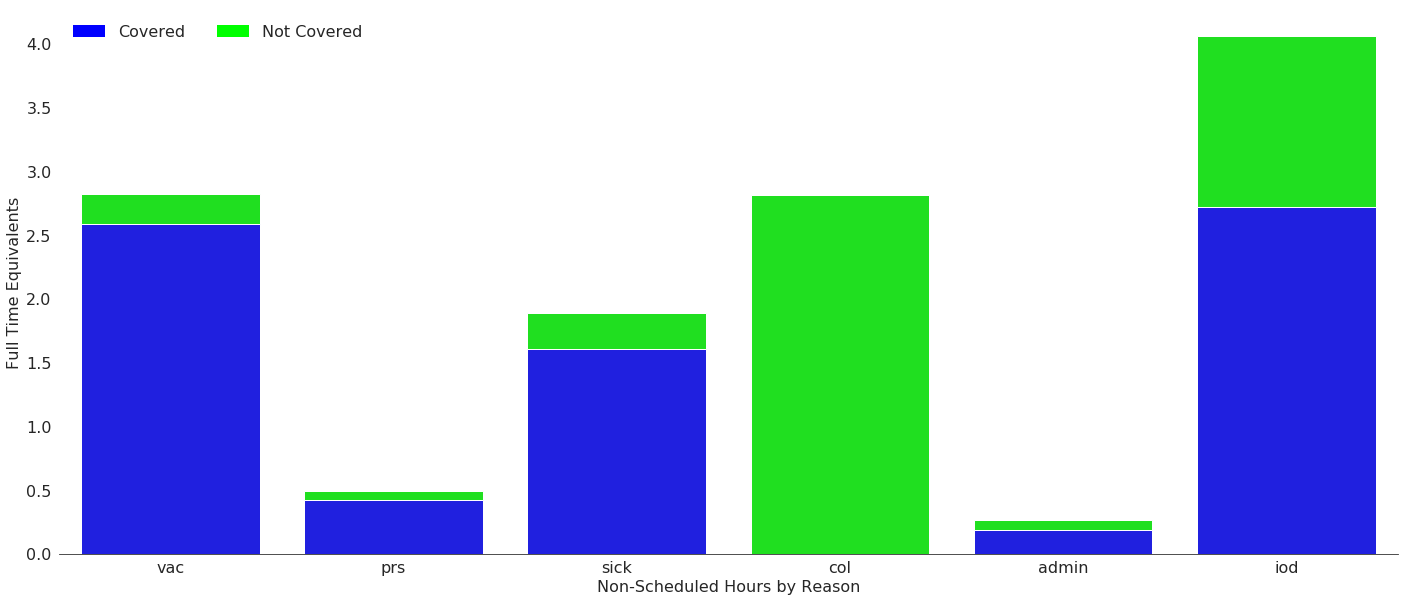

In [38]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

stacked_bar_data_groups = []
for key in tot.keys():
    stacked_bar_data_groups.append(key)

stacked_bar_data = []

for key in stacked_bar_data_groups:
    stacked_bar_data.append(covered[key])

stacked_bar_data_total = []

for key in stacked_bar_data_groups:
    stacked_bar_data_total.append(tot[key])

#Set general plot properties
sns.set_style("white")
sns.set_context({"figure.figsize": (24, 10)})

#Plot 1 - background - "total" (top) series
sns.barplot(x = stacked_bar_data_groups, y = stacked_bar_data_total, color = "#00FF00")

#Plot 2 - overlay - "bottom" series
bottom_plot = sns.barplot(x = stacked_bar_data_groups, y = stacked_bar_data, color = "#0000FF")


topbar = plt.Rectangle((0,0),1,1,fc="#00FF00", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#0000FF',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Covered', 'Not Covered'], loc=2, ncol = 2, prop={'size':16})
l.draw_frame(False)

#Optional code - Make plot look nicer
sns.despine(left=True)
bottom_plot.set_ylabel("Full Time Equivalents")
bottom_plot.set_xlabel("Non-Scheduled Hours by Reason")

#Set fonts to consistent 16pt size
for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
             bottom_plot.get_xticklabels() + bottom_plot.get_yticklabels()):
    item.set_fontsize(16)

In [39]:
def scheduled_this_cycle(cs):            #returns the four shifts scheduled in this cycle
    
    ts_list = []
    ts = cs
    ts_list.append(ts)
    ts += datetime.timedelta(days=1)
    ts_list.append(ts)
    ts += datetime.timedelta(days=1)
    ts += datetime.timedelta(hours=10)   # increment cycle start by 10 hours + 1 day
    ts_list.append(ts)
    ts += datetime.timedelta(days=1)
    ts_list.append(ts)
    return(ts_list)

In [40]:
def this_cycle(cs):            #returns the 16 shifts scheduled in this 8-day cycle
    
    cy_list = []
    ts = cs
    for hrs in [0,10,14,10,14,10,14,10,14,10,14,10,14,10,14,10]:
        ts += datetime.timedelta(hours=hrs)
        cy_list.append(ts)
    return(cy_list)

In [41]:
def shift_hours(token,ts,shifts):            #returns a dictionary with all hours for this cycle
    
    sh = {}
    
    try:
        this_ff = shifts[token]['shifts'][ts]   #see if they have a record for this shift
        if ('acct' in this_ff.keys()):
            typ = this_ff['acct']['type']
            sh[typ] = this_ff['acct']['hours']
        if ('type' in this_ff.keys()):
            typ = this_ff['type']
            if (ts.hour == 7): sh[typ] = 10.0
            if (ts.hour == 17): sh[typ] = 14.0
    except KeyError:
            ;
    return(sh)
            

In [42]:
def full_shift(ts):
    if (ts.hour == 7): hours = 10.0
    if (ts.hour == 17): hours = 14.0
    return(hours)

In [43]:
def disp_val(typ,dct):
    disp_val = '&nbsp'
    if (typ in dct.keys()):
        if (dct[typ] > 0.0): disp_val = str(dct[typ])
    return(disp_val)

In [44]:
def add_hours(dct,key,x):
    if (key in dct.keys()):
        dct[key] += x
    else:
        dct[key] = x
    return()

In [45]:
def add_cumulative_hours(dct,totdct):
    for key in dct.keys():
        if (key in totdct.keys()):
            totdct[key] += dct[key]
        else:
            totdct[key] = dct[key]
    return()

In [46]:
def write_column_headings(file):
    file.write('<table border="1" width="100%">')
    file.write('<tr><td>FF</td>')
    file.write('<td>Scheduled</td>')
    file.write('<td>Regular</td>')
    file.write('<td>VC</td>')
    file.write('<td>SL</td>')
    file.write('<td>IOD</td>')
    file.write('<td>SWAP</td>')
    file.write('<td>CD</td>')
    file.write('<td>OT</td>')
    file.write('<td>OT-VAC</td>')
    file.write('<td>OT-SL</td>')
    file.write('<td>OT-IOD</td>')
    file.write('</tr>\n')
    return()

In [47]:
def write_cycle_row(token,cycle_hours,file):
    file.write('<tr><td>' + token + '</td>')
    file.write('<td>' + disp_val('scheduled',cycle_hours) + '</td>')
    file.write('<td>' + disp_val('reg_hours',cycle_hours) +'</td>')
    file.write('<td>' + disp_val('VC',cycle_hours) +'</td>')
    file.write('<td>' + disp_val('SL',cycle_hours) +'</td>')
    file.write('<td>' + disp_val('IOD',cycle_hours) +'</td>')
    file.write('<td>' + disp_val('SWAP',cycle_hours) +'</td>')
    file.write('<td>' + disp_val('C-DD',cycle_hours) +'</td>')
    file.write('<td>' + disp_val('OT',cycle_hours) +'</td>')
    file.write('<td>' + disp_val('OT-VC',cycle_hours) +'</td>')
    file.write('<td>' + disp_val('OT-SL',cycle_hours) +'</td>')
    file.write('<td>' + disp_val('OT_IOD',cycle_hours) +'</td>')
    file.write('</tr></td>')
    return()

In [48]:
def cycle_hours(token,cs,shifts):            #returns a dictionary with all hours for this cycle
    
    ch = {}
    
    all_shifts = this_cycle(cs)   
    
    for shift in all_shifts:
        try:
            this_ff = shifts[token]['shifts'][shift]   #see if they have a record for this shift
            if ('acct' in this_ff.keys()):
                typ = this_ff['acct']['type']
                if (typ in ch.keys()):
                    ch[typ] += this_ff['acct']['hours']
                else:
                    ch[typ] = this_ff['acct']['hours']
            elif ('type' in this_ff.keys()):
                typ = this_ff['type']
                if (typ in ch.keys()):
                    ch[typ] += full_shift(shift)
                else:
                    ch[typ] = full_shift(shift)
        except KeyError:
            ;
    if ((len(ch) > 0) & ('scheduled' not in ch.keys())):
        ch['scheduled'] = 0.0
    return(ch)
            

In [49]:
cycle_totals = {}

for platoon in ['A','B','C','D']:
    for first_shift in cycle_start[platoon]:
        for ffn in ['OF1','OF2','OF3','OF4','FF1','FF2','FF3','FF4','FF5']:
            token = platoon + ffn
            cyc_hours = cycle_hours(token,first_shift,shifts)  
            cyc_key = token + str(first_shift)
            cycle_totals[cyc_key] = cyc_hours


In [50]:
cycle_totals

{'AOF12017-06-04 07:00:00': {'scheduled': 34.0, 'VC': 14.0, 'DP': 4.0},
 'AOF22017-06-04 07:00:00': {'scheduled': 48.0, 'DP': 4.0},
 'AOF32017-06-04 07:00:00': {'scheduled': 38.0,
  'SWAPW': 14.0,
  'VC': 10.0,
  'CS-TRN': 7.5,
  'CMP-E': 6.0},
 'AOF42017-06-04 07:00:00': {'scheduled': 34.0,
  'OT-VC': 28.0,
  'OT-BARG': 6.0,
  'VC': 14.0,
  'CMP-E': 6.0},
 'AFF12017-06-04 07:00:00': {'VC': 10.0, 'scheduled': 38.0},
 'AFF22017-06-04 07:00:00': {'scheduled': 48.0, 'CMP-E': 6.5},
 'AFF32017-06-04 07:00:00': {'scheduled': 48.0, 'CMP-E': 6.0},
 'AFF42017-06-04 07:00:00': {'scheduled': 48.0, 'OT-COMP': 10.0, 'CMP-E': 6.0},
 'AFF52017-06-04 07:00:00': {'IOD': 48.0, 'scheduled': 0.0},
 'AOF12017-06-12 07:00:00': {'scheduled': 34.0, 'OT': 0.5, 'VC': 14.0},
 'AOF22017-06-12 07:00:00': {'scheduled': 20.0, 'SL': 28.0},
 'AOF32017-06-12 07:00:00': {'scheduled': 48.0, 'OT-VC': 24.0},
 'AOF42017-06-12 07:00:00': {'scheduled': 48.0, 'SWAPW': 2.0, 'OT-IOD': 14.0},
 'AFF12017-06-12 07:00:00': {'schedul

In [51]:
ot = {}

for ffshift in cycle_totals.keys():
    ot[ffshift] = {}
    ot[ffshift]['OT'] = 0.0
    ot[ffshift]['LR'] = 0.0
    ot[ffshift]['scheduled'] = 0.0
    for typ in cycle_totals[ffshift].keys():
        hrs = cycle_totals[ffshift][typ]
        if (typ == 'scheduled'):
            ot[ffshift]['scheduled'] = hrs
        if ('OT' in typ):
            if (typ == 'OT'):  ot[ffshift]['LR'] += hrs
            else: ot[ffshift]['OT'] += hrs
            
        

In [60]:
for ffk in ot.keys():
    if (ot[ffk]['scheduled'] < 11.0):
        if (ot[ffk]['OT'] > 14.0):
            print(token_FF[ffk[0:4]])
            print(ffk)
            print(ot[ffk])

Capt Montville
AOF32018-02-15 07:00:00
{'OT': 28.0, 'LR': 0.0, 'scheduled': 10.0}
FF Columbier
BFF12017-06-30 07:00:00
{'OT': 24.0, 'LR': 0.0, 'scheduled': 10.0}
FF Snowling
BFF22017-07-08 07:00:00
{'OT': 38.0, 'LR': 0.0, 'scheduled': 10.0}
Lt Grady
BOF42017-08-17 07:00:00
{'OT': 28.0, 'LR': 0.0, 'scheduled': 10.0}
Lt Beaudreau
BOF32017-08-25 07:00:00
{'OT': 24.0, 'LR': 0.0, 'scheduled': 0.0}
Lt Beaudreau
BOF32018-03-05 07:00:00
{'OT': 28.0, 'LR': 0.0, 'scheduled': 10.0}
Capt Mears
COF12018-02-11 07:00:00
{'OT': 48.0, 'LR': 0.0, 'scheduled': 0.0}
FF McKeon
CFF52018-03-15 07:00:00
{'OT': 38.0, 'LR': 0.0, 'scheduled': 10.0}
Lt Babcock
DOF22017-06-18 07:00:00
{'OT': 24.0, 'LR': 0.0, 'scheduled': 0.0}


In [52]:
ot_fs  = 0.0
ot_nfs = 0.0
lr_fs = 0.0
lr_nfs = 0.0

for ffshift in ot.keys():
    if (ot[ffshift]['scheduled'] < 48.0):
        ot_nfs += ot[ffshift]['OT']
        lr_nfs += ot[ffshift]['LR']
    else:
        ot_fs += ot[ffshift]['OT']
        lr_fs += ot[ffshift]['LR']
        
print(ot_fs)
print(ot_nfs)
print(lr_fs)
print(lr_nfs)


8024.0
8984.75
429.5
418.0


In [53]:
file = open('../summary.html','w') 

file.write('<html><body>') 

file.write('<table border="1" width="80%">')

total_hours = {}

cycle_count = 0

for platoon in ['A','B','C','D']:
    
    for cs in cycle_start[platoon].keys():
        cycle_count += 1
        file.write('<tr><td>')
        file.write('<table border="1" width="100%"><tr><td>Platoon</td><td>Cycle Start</td></tr>')
        file.write('<tr><td>' + platoon + '</td><td>' + str(cs) + '</td></tr></table>\n')
        full_cycle = this_cycle(cs)
        print(cs)
        print('new cycle***********************************')
        write_column_headings(file)
        for ffn in ['OF1','OF2','OF3','OF4','FF1','FF2','FF3','FF4','FF5']:
            token = platoon+ ffn
            print(token)
            cycle_hours = {}                            #hours for this FF in this 8-day cycle
            for ts in full_cycle:
                try:
                    ds = shifts[token]['shifts'][ts]
                    print(ts)
                    print(ds)
                    try:                                  #if this FF was scheduled, show full shift scheduled
                        typ = ds['type']
                        if (typ == 'scheduled'):      #if this is the only entry FF worked full shift
                            add_hours(cycle_hours,'scheduled',full_shift(ts))
                    except KeyError:
                        ;
                    if ('acct' not in ds.keys()):      #if this is the only entry FF worked full shift
                            add_hours(cycle_hours,'reg_hours',full_shift(ts))
                    try:
                        typ = ds['acct']['type']
                        add_hours(cycle_hours,typ,ds['acct']['hours'])
                    except KeyError:
                        ;

                except KeyError:
                    ;
                print(ts)
                print(cycle_hours)
            write_cycle_row(token,cycle_hours,file)
            add_cumulative_hours(cycle_hours,total_hours)

        file.write('</table></td></tr>')
        file.write('\n')

total_hours['cycle_count'] = cycle_count

print(total_hours)

file.write('<tr><td><table border="1" width="100%">')
file.write('<tr><td>ALL</td>')
file.write('<td>8-Day Cycles</td>')
file.write('<td>Scheduled</td>')
file.write('<td>Regular</td>')
file.write('<td>VC</td>')
file.write('<td>SL</td>')
file.write('<td>IOD</td>')
file.write('<td>SWAP</td>')
file.write('<td>CD</td>')
file.write('<td>OT</td>')
file.write('<td>OT-VAC</td>')
file.write('<td>OT-SL</td>')
file.write('<td>OT-IOD</td>')
file.write('</tr>')
file.write('<tr><td>Totals</td>')
file.write('<td>' + disp_val('cycle_count',total_hours) + '</td>')
file.write('<td>' + disp_val('scheduled',total_hours) + '</td>')
file.write('<td>' + disp_val('reg_hours',total_hours) +'</td>')
file.write('<td>' + disp_val('VC',total_hours) +'</td>')
file.write('<td>' + disp_val('SL',total_hours) +'</td>')
file.write('<td>' + disp_val('IOD',total_hours) +'</td>')
file.write('<td>' + disp_val('SWAP',total_hours) +'</td>')
file.write('<td>' + disp_val('C-DD',total_hours) +'</td>')
file.write('<td>' + disp_val('OT',total_hours) +'</td>')
file.write('<td>' + disp_val('OT-VC',total_hours) +'</td>')
file.write('<td>' + disp_val('OT-SL',total_hours) +'</td>')
file.write('<td>' + disp_val('OT_IOD',total_hours) +'</td>')
file.write('</tr></td>')
file.write('</table></td></tr>')
file.write('</table>')
file.write('\n')

        

2017-06-04 07:00:00
new cycle***********************************
AOF1
2017-06-04 07:00:00
{'type': 'scheduled'}
2017-06-04 07:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2017-06-04 17:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2017-06-05 07:00:00
{'type': 'scheduled'}
2017-06-05 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2017-06-05 17:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2017-06-06 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2017-06-06 17:00:00
{'type': 'scheduled'}
2017-06-06 17:00:00
{'scheduled': 34.0, 'reg_hours': 34.0}
2017-06-07 07:00:00
{'scheduled': 34.0, 'reg_hours': 34.0}
2017-06-07 17:00:00
{'type': 'scheduled', 'acct': {'type': 'VC', 'hours': 14.0, 'rank': 'Lt', 'reason': 'Vacation', 'for_token': '', 'clean_reason': 'Vacation'}}
2017-06-07 17:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'VC': 14.0}
2017-06-08 07:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'VC': 14.0}
2017-06-08 17:00:00
{'acct': {'type': 'DP', 'hours': 4.0, 'rank': 'Lt', 'reason': 'Odeu

2017-07-19 17:00:00
{'scheduled': 48.0, 'ADMIN': 34.0, 'SWAP': 14.0}
2017-07-20 07:00:00
{'scheduled': 48.0, 'ADMIN': 34.0, 'SWAP': 14.0}
2017-07-20 17:00:00
{'scheduled': 48.0, 'ADMIN': 34.0, 'SWAP': 14.0}
2017-07-21 07:00:00
{'scheduled': 48.0, 'ADMIN': 34.0, 'SWAP': 14.0}
2017-07-21 17:00:00
{'scheduled': 48.0, 'ADMIN': 34.0, 'SWAP': 14.0}
AOF4
2017-07-14 07:00:00
{'type': 'scheduled', 'acct': {'type': 'ADMIN', 'hours': 10.0, 'rank': 'Lt', 'reason': 'Administrative', 'for_token': '', 'clean_reason': 'Administrative'}}
2017-07-14 07:00:00
{'scheduled': 10.0, 'ADMIN': 10.0}
2017-07-14 17:00:00
{'scheduled': 10.0, 'ADMIN': 10.0}
2017-07-15 07:00:00
{'type': 'scheduled', 'acct': {'type': 'ADMIN', 'hours': 10.0, 'rank': 'Lt', 'reason': 'Administrative', 'for_token': '', 'clean_reason': 'Administrative'}}
2017-07-15 07:00:00
{'scheduled': 20.0, 'ADMIN': 20.0}
2017-07-15 17:00:00
{'scheduled': 20.0, 'ADMIN': 20.0}
2017-07-16 07:00:00
{'scheduled': 20.0, 'ADMIN': 20.0}
2017-07-16 17:00:00
{

{'scheduled': 48.0, 'reg_hours': 48.0}
2017-08-29 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2017-08-30 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2017-08-30 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
AOF3
2017-08-23 07:00:00
{'type': 'scheduled', 'acct': {'type': 'VC', 'hours': 10.0, 'rank': 'Capt', 'reason': 'Vacation', 'for_token': '', 'clean_reason': 'Vacation'}}
2017-08-23 07:00:00
{'scheduled': 10.0, 'VC': 10.0}
2017-08-23 17:00:00
{'scheduled': 10.0, 'VC': 10.0}
2017-08-24 07:00:00
{'type': 'scheduled'}
2017-08-24 07:00:00
{'scheduled': 20.0, 'VC': 10.0, 'reg_hours': 10.0}
2017-08-24 17:00:00
{'scheduled': 20.0, 'VC': 10.0, 'reg_hours': 10.0}
2017-08-25 07:00:00
{'scheduled': 20.0, 'VC': 10.0, 'reg_hours': 10.0}
2017-08-25 17:00:00
{'type': 'scheduled', 'acct': {'type': 'SL', 'hours': 14.0, 'rank': 'Capt', 'reason': 'Sick', 'for_token': '', 'clean_reason': 'Sick'}}
2017-08-25 17:00:00
{'scheduled': 34.0, 'VC': 10.0, 'reg_hours': 10.0, 'SL': 14.0}
2017-08-26 07:00:

{'scheduled': 20.0, 'VC': 10.0, 'reg_hours': 10.0}
2017-09-26 07:00:00
{'scheduled': 20.0, 'VC': 10.0, 'reg_hours': 10.0}
2017-09-26 17:00:00
{'type': 'scheduled'}
2017-09-26 17:00:00
{'scheduled': 34.0, 'VC': 10.0, 'reg_hours': 24.0}
2017-09-27 07:00:00
{'scheduled': 34.0, 'VC': 10.0, 'reg_hours': 24.0}
2017-09-27 17:00:00
{'type': 'scheduled'}
2017-09-27 17:00:00
{'scheduled': 48.0, 'VC': 10.0, 'reg_hours': 38.0}
2017-09-28 07:00:00
{'scheduled': 48.0, 'VC': 10.0, 'reg_hours': 38.0}
2017-09-28 17:00:00
{'scheduled': 48.0, 'VC': 10.0, 'reg_hours': 38.0}
2017-09-29 07:00:00
{'scheduled': 48.0, 'VC': 10.0, 'reg_hours': 38.0}
2017-09-29 17:00:00
{'scheduled': 48.0, 'VC': 10.0, 'reg_hours': 38.0}
2017-09-30 07:00:00
{'scheduled': 48.0, 'VC': 10.0, 'reg_hours': 38.0}
2017-09-30 17:00:00
{'scheduled': 48.0, 'VC': 10.0, 'reg_hours': 38.0}
2017-10-01 07:00:00
{'scheduled': 48.0, 'VC': 10.0, 'reg_hours': 38.0}
2017-10-01 17:00:00
{'scheduled': 48.0, 'VC': 10.0, 'reg_hours': 38.0}
AFF1
2017-09-

2017-11-07 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-PRS': 14.0}
2017-11-08 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-PRS': 14.0}
2017-11-08 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-PRS': 14.0}
2017-11-09 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-PRS': 14.0}
2017-11-09 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-PRS': 14.0}
2017-11-10 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-PRS': 14.0}
2017-11-10 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-PRS': 14.0}
AFF2
2017-11-03 07:00:00
{'type': 'scheduled'}
2017-11-03 07:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2017-11-03 17:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2017-11-04 07:00:00
{'type': 'scheduled', 'acct': {'type': 'VC', 'hours': 10.0, 'rank': 'FF', 'reason': 'Vacation', 'for_token': '', 'clean_reason': 'Vacation'}}
2017-11-04 07:00:00
{'scheduled': 20.0, 'reg_hours': 10.0, 'VC': 10.0}
2017-11-04 17:00:00
{'scheduled': 20.0, 'reg_hours': 10.0, 'VC': 10.0}
2017-1

2017-12-13 17:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2017-12-14 07:00:00
{'type': 'scheduled'}
2017-12-14 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2017-12-14 17:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2017-12-15 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2017-12-15 17:00:00
{'type': 'scheduled'}
2017-12-15 17:00:00
{'scheduled': 34.0, 'reg_hours': 34.0}
2017-12-16 07:00:00
{'scheduled': 34.0, 'reg_hours': 34.0}
2017-12-16 17:00:00
{'type': 'scheduled', 'acct': {'type': 'PRS', 'hours': 14.0, 'rank': 'FF', 'reason': 'Personal Day', 'for_token': '', 'clean_reason': 'Personal Day'}}
2017-12-16 17:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'PRS': 14.0}
2017-12-17 07:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'PRS': 14.0}
2017-12-17 17:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'PRS': 14.0}
2017-12-18 07:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'PRS': 14.0}
2017-12-18 17:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'PRS': 14.0}
2017-12-19 07:00:00
{'scheduled

{'type': 'scheduled'}
2018-01-23 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2018-01-23 17:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2018-01-24 07:00:00
{'acct': {'type': 'C-DD', 'hours': 10.0, 'rank': 'Prob-FF', 'reason': 'DISPATCH', 'for_token': '', 'clean_reason': 'DISPATCH'}}
2018-01-24 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0, 'C-DD': 10.0}
2018-01-24 17:00:00
{'type': 'scheduled'}
2018-01-24 17:00:00
{'scheduled': 34.0, 'reg_hours': 34.0, 'C-DD': 10.0}
2018-01-25 07:00:00
{'acct': {'type': 'OT-IOD', 'hours': 10.0, 'rank': 'Prob-FF', 'reason': 'FF Snowling, Gregg - Injured On Duty', 'for_token': 'BFF2', 'clean_reason': 'BFF2- Injured On Duty'}}
2018-01-25 07:00:00
{'scheduled': 34.0, 'reg_hours': 34.0, 'C-DD': 10.0, 'OT-IOD': 10.0}
2018-01-25 17:00:00
{'type': 'scheduled'}
2018-01-25 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'C-DD': 10.0, 'OT-IOD': 10.0}
2018-01-26 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'C-DD': 10.0, 'OT-IOD': 10.0}
2018-01-26 17:00:00


{'scheduled': 48.0, 'VC': 20.0, 'reg_hours': 28.0}
2018-03-07 17:00:00
{'scheduled': 48.0, 'VC': 20.0, 'reg_hours': 28.0}
2018-03-08 07:00:00
{'scheduled': 48.0, 'VC': 20.0, 'reg_hours': 28.0}
2018-03-08 17:00:00
{'scheduled': 48.0, 'VC': 20.0, 'reg_hours': 28.0}
2018-03-09 07:00:00
{'scheduled': 48.0, 'VC': 20.0, 'reg_hours': 28.0}
2018-03-09 17:00:00
{'scheduled': 48.0, 'VC': 20.0, 'reg_hours': 28.0}
2018-03-10 07:00:00
{'scheduled': 48.0, 'VC': 20.0, 'reg_hours': 28.0}
2018-03-10 17:00:00
{'scheduled': 48.0, 'VC': 20.0, 'reg_hours': 28.0}
AFF5
2018-03-03 07:00:00
{'type': 'scheduled', 'acct': {'type': 'SL', 'hours': 10.0, 'rank': 'FF', 'reason': 'Sick', 'for_token': '', 'clean_reason': 'Sick'}}
2018-03-03 07:00:00
{'scheduled': 10.0, 'SL': 10.0}
2018-03-03 17:00:00
{'scheduled': 10.0, 'SL': 10.0}
2018-03-04 07:00:00
{'type': 'scheduled', 'acct': {'type': 'SL', 'hours': 10.0, 'rank': 'FF', 'reason': 'Sick', 'for_token': '', 'clean_reason': 'Sick'}}
2018-03-04 07:00:00
{'scheduled': 2

2018-04-14 17:00:00
{'scheduled': 34.0, 'SL': 34.0}
2018-04-15 07:00:00
{'scheduled': 34.0, 'SL': 34.0}
2018-04-15 17:00:00
{'type': 'scheduled', 'acct': {'type': 'SL', 'hours': 14.0, 'rank': 'FF', 'reason': 'Sick', 'for_token': '', 'clean_reason': 'Sick'}}
2018-04-15 17:00:00
{'scheduled': 48.0, 'SL': 48.0}
2018-04-16 07:00:00
{'scheduled': 48.0, 'SL': 48.0}
2018-04-16 17:00:00
{'scheduled': 48.0, 'SL': 48.0}
2018-04-17 07:00:00
{'scheduled': 48.0, 'SL': 48.0}
2018-04-17 17:00:00
{'scheduled': 48.0, 'SL': 48.0}
2018-04-18 07:00:00
{'scheduled': 48.0, 'SL': 48.0}
2018-04-18 17:00:00
{'scheduled': 48.0, 'SL': 48.0}
2018-04-19 07:00:00
{'scheduled': 48.0, 'SL': 48.0}
2018-04-19 17:00:00
{'scheduled': 48.0, 'SL': 48.0}
2018-04-20 07:00:00
new cycle***********************************
AOF1
2018-04-20 07:00:00
{'type': 'scheduled'}
2018-04-20 07:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2018-04-20 17:00:00
{'acct': {'type': 'OT-VC', 'hours': 14.0, 'rank': 'Lt', 'reason': 'Lt Hall, Keith (

{'type': 'scheduled'}
2017-06-08 17:00:00
{'scheduled': 34.0, 'PRS': 10.0, 'reg_hours': 24.0, 'OT-IOD': 10.0}
2017-06-09 07:00:00
{'acct': {'type': 'OT-PRS', 'hours': 10.0, 'rank': 'Prob-FF', 'reason': 'FF King, Kevin - Personal Day', 'for_token': 'CFF1', 'clean_reason': 'CFF1- Personal Day'}}
2017-06-09 07:00:00
{'scheduled': 34.0, 'PRS': 10.0, 'reg_hours': 24.0, 'OT-IOD': 10.0, 'OT-PRS': 10.0}
2017-06-09 17:00:00
{'type': 'scheduled'}
2017-06-09 17:00:00
{'scheduled': 48.0, 'PRS': 10.0, 'reg_hours': 38.0, 'OT-IOD': 10.0, 'OT-PRS': 10.0}
2017-06-10 07:00:00
{'scheduled': 48.0, 'PRS': 10.0, 'reg_hours': 38.0, 'OT-IOD': 10.0, 'OT-PRS': 10.0}
2017-06-10 17:00:00
{'scheduled': 48.0, 'PRS': 10.0, 'reg_hours': 38.0, 'OT-IOD': 10.0, 'OT-PRS': 10.0}
2017-06-11 07:00:00
{'acct': {'type': 'CMP-E', 'hours': 6.0, 'rank': 'Prob-FF', 'reason': 'FF Sunday', 'for_token': '', 'clean_reason': 'FF Sunday'}}
2017-06-11 07:00:00
{'scheduled': 48.0, 'PRS': 10.0, 'reg_hours': 38.0, 'OT-IOD': 10.0, 'OT-PRS':

{'scheduled': 48.0, 'VC': 10.0, 'SWAP': 24.0, 'C-DD': 10.0, 'reg_hours': 14.0, 'CS-SCBA': 2.0, 'OT-IOD': 10.0, 'C-ND': 14.0}
2017-07-23 07:00:00
{'acct': {'type': 'OT-VC', 'hours': 10.0, 'rank': 'FF', 'reason': "FF O'Donnell, Peter - Vacation", 'for_token': 'AFF2', 'clean_reason': 'AFF2- Vacation'}}
2017-07-23 07:00:00
{'scheduled': 48.0, 'VC': 10.0, 'SWAP': 24.0, 'C-DD': 10.0, 'reg_hours': 14.0, 'CS-SCBA': 2.0, 'OT-IOD': 10.0, 'C-ND': 14.0, 'OT-VC': 10.0}
2017-07-23 17:00:00
{'scheduled': 48.0, 'VC': 10.0, 'SWAP': 24.0, 'C-DD': 10.0, 'reg_hours': 14.0, 'CS-SCBA': 2.0, 'OT-IOD': 10.0, 'C-ND': 14.0, 'OT-VC': 10.0}
BFF2
2017-07-16 07:00:00
{'type': 'scheduled'}
2017-07-16 07:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2017-07-16 17:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2017-07-17 07:00:00
{'type': 'scheduled'}
2017-07-17 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2017-07-17 17:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2017-07-18 07:00:00
{'scheduled': 20.0, 'reg_hours': 2

{'scheduled': 48.0, 'reg_hours': 48.0, 'C-ND': 14.0, 'OT-VC': 34.0, 'CS-EMS': 5.5}
BOF3
2017-08-25 07:00:00
{'type': 'scheduled', 'acct': {'type': 'PRS', 'hours': 10.0, 'rank': 'Lt', 'reason': 'Personal Day', 'for_token': '', 'clean_reason': 'Personal Day'}}
2017-08-25 07:00:00
{'scheduled': 10.0, 'PRS': 10.0}
2017-08-25 17:00:00
{'scheduled': 10.0, 'PRS': 10.0}
2017-08-26 07:00:00
{'type': 'scheduled', 'acct': {'type': 'SWAP', 'hours': 10.0, 'rank': 'Lt', 'reason': 'SWAP-OUT', 'for_token': '', 'clean_reason': 'SWAP-OUT'}}
2017-08-26 07:00:00
{'scheduled': 20.0, 'PRS': 10.0, 'SWAP': 10.0}
2017-08-26 17:00:00
{'scheduled': 20.0, 'PRS': 10.0, 'SWAP': 10.0}
2017-08-27 07:00:00
{'scheduled': 20.0, 'PRS': 10.0, 'SWAP': 10.0}
2017-08-27 17:00:00
{'type': 'scheduled', 'acct': {'type': 'SWAP', 'hours': 14.0, 'rank': 'Lt', 'reason': 'SWAP-OUT', 'for_token': '', 'clean_reason': 'SWAP-OUT'}}
2017-08-27 17:00:00
{'scheduled': 34.0, 'PRS': 10.0, 'SWAP': 24.0}
2017-08-28 07:00:00
{'acct': {'type': '

{'type': 'scheduled'}
2017-09-28 17:00:00
{'scheduled': 34.0, 'reg_hours': 34.0}
2017-09-29 07:00:00
{'scheduled': 34.0, 'reg_hours': 34.0}
2017-09-29 17:00:00
{'type': 'scheduled'}
2017-09-29 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2017-09-30 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2017-09-30 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2017-10-01 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2017-10-01 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2017-10-02 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2017-10-02 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2017-10-03 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2017-10-03 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2017-10-04 07:00:00
new cycle***********************************
BOF1
2017-10-04 07:00:00
{'type': 'scheduled'}
2017-10-04 07:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2017-10-04 17:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2017-10-05 07:00:00
{'type': 'scheduled'}
2017-10-05 07:0

{'type': 'scheduled', 'acct': {'type': 'SL', 'hours': 10.0, 'rank': 'Prob-FF', 'reason': 'Sick', 'for_token': '', 'clean_reason': 'Sick'}}
2017-11-05 07:00:00
{'scheduled': 10.0, 'SL': 10.0}
2017-11-05 17:00:00
{'scheduled': 10.0, 'SL': 10.0}
2017-11-06 07:00:00
{'type': 'scheduled'}
2017-11-06 07:00:00
{'scheduled': 20.0, 'SL': 10.0, 'reg_hours': 10.0}
2017-11-06 17:00:00
{'scheduled': 20.0, 'SL': 10.0, 'reg_hours': 10.0}
2017-11-07 07:00:00
{'scheduled': 20.0, 'SL': 10.0, 'reg_hours': 10.0}
2017-11-07 17:00:00
{'type': 'scheduled'}
2017-11-07 17:00:00
{'scheduled': 34.0, 'SL': 10.0, 'reg_hours': 24.0}
2017-11-08 07:00:00
{'acct': {'type': 'OT-SL', 'hours': 10.0, 'rank': 'Prob-FF', 'reason': 'FF McKeon, Steven - Sick', 'for_token': 'CFF5', 'clean_reason': 'CFF5- Sick'}}
2017-11-08 07:00:00
{'scheduled': 34.0, 'SL': 10.0, 'reg_hours': 24.0, 'OT-SL': 10.0}
2017-11-08 17:00:00
{'type': 'scheduled'}
2017-11-08 17:00:00
{'scheduled': 48.0, 'SL': 10.0, 'reg_hours': 38.0, 'OT-SL': 10.0}
2017

{'scheduled': 34.0, 'IOD': 34.0}
2017-12-18 07:00:00
{'scheduled': 34.0, 'IOD': 34.0}
2017-12-18 17:00:00
{'type': 'scheduled', 'acct': {'type': 'IOD', 'hours': 14.0, 'rank': 'FF', 'reason': 'Injured On Duty', 'for_token': '', 'clean_reason': 'Injured On Duty'}}
2017-12-18 17:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2017-12-19 07:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2017-12-19 17:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2017-12-20 07:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2017-12-20 17:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2017-12-21 07:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2017-12-21 17:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2017-12-22 07:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2017-12-22 17:00:00
{'scheduled': 48.0, 'IOD': 48.0}
BFF3
2017-12-15 07:00:00
{'type': 'scheduled'}
2017-12-15 07:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2017-12-15 17:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2017-12-16 07:00:00
{'type': 'scheduled'}
2017-12-16 07:00:00
{'scheduled': 20.0, 'reg_hours': 

2018-01-27 17:00:00
{'type': 'scheduled', 'acct': {'type': 'IOD', 'hours': 14.0, 'rank': 'Lt', 'reason': 'Injured On Duty', 'for_token': '', 'clean_reason': 'Injured On Duty'}}
2018-01-27 17:00:00
{'scheduled': 48.0, 'IOD': 43.5}
2018-01-28 07:00:00
{'scheduled': 48.0, 'IOD': 43.5}
2018-01-28 17:00:00
{'scheduled': 48.0, 'IOD': 43.5}
2018-01-29 07:00:00
{'scheduled': 48.0, 'IOD': 43.5}
2018-01-29 17:00:00
{'scheduled': 48.0, 'IOD': 43.5}
2018-01-30 07:00:00
{'scheduled': 48.0, 'IOD': 43.5}
2018-01-30 17:00:00
{'scheduled': 48.0, 'IOD': 43.5}
2018-01-31 07:00:00
{'scheduled': 48.0, 'IOD': 43.5}
2018-01-31 17:00:00
{'scheduled': 48.0, 'IOD': 43.5}
BFF1
2018-01-24 07:00:00
{'type': 'scheduled', 'acct': {'type': 'ACT', 'hours': 3.5, 'rank': 'Lt', 'reason': nan}}
2018-01-24 07:00:00
{'scheduled': 10.0, 'ACT': 3.5}
2018-01-24 17:00:00
{'acct': {'type': 'ACTOT', 'hours': 1.0, 'rank': 'FF', 'reason': 'acting at on R2 late run', 'for_token': '', 'clean_reason': 'acting at on R2 late run'}}
2018

2018-03-05 07:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2018-03-05 17:00:00
{'acct': {'type': 'OT', 'hours': 1.0, 'rank': 'Lt', 'reason': 'Held Over Run # 794', 'for_token': '', 'clean_reason': 'Held Over Run # 794'}}
2018-03-05 17:00:00
{'scheduled': 10.0, 'reg_hours': 10.0, 'OT': 1.0}
2018-03-06 07:00:00
{'type': 'scheduled'}
2018-03-06 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0, 'OT': 1.0}
2018-03-06 17:00:00
{'acct': {'type': 'C-ND', 'hours': 14.0, 'rank': 'Lt', 'reason': 'Dispatch', 'for_token': '', 'clean_reason': 'Dispatch'}}
2018-03-06 17:00:00
{'scheduled': 20.0, 'reg_hours': 20.0, 'OT': 1.0, 'C-ND': 14.0}
2018-03-07 07:00:00
{'acct': {'type': 'OT-IOD', 'hours': 10.0, 'rank': 'Lt', 'reason': 'Lt Purcell, William (D) - Injured On Duty', 'for_token': 'COF3', 'clean_reason': 'COF3- Injured On Duty'}}
2018-03-07 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0, 'OT': 1.0, 'C-ND': 14.0, 'OT-IOD': 10.0}
2018-03-07 17:00:00
{'type': 'scheduled'}
2018-03-07 17:00:00
{'scheduled':

2018-04-10 17:00:00
{'scheduled': 48.0, 'reg_hours': 20.0, 'SWAP': 28.0}
2018-04-11 07:00:00
{'acct': {'type': 'C-DD', 'hours': 10.0, 'rank': 'Prob-FF', 'reason': 'Dispatch Day Shift', 'for_token': '', 'clean_reason': 'Dispatch Day Shift'}}
2018-04-11 07:00:00
{'scheduled': 48.0, 'reg_hours': 20.0, 'SWAP': 28.0, 'C-DD': 10.0}
2018-04-11 17:00:00
{'scheduled': 48.0, 'reg_hours': 20.0, 'SWAP': 28.0, 'C-DD': 10.0}
2018-04-12 07:00:00
{'scheduled': 48.0, 'reg_hours': 20.0, 'SWAP': 28.0, 'C-DD': 10.0}
2018-04-12 17:00:00
{'scheduled': 48.0, 'reg_hours': 20.0, 'SWAP': 28.0, 'C-DD': 10.0}
2018-04-13 07:00:00
{'scheduled': 48.0, 'reg_hours': 20.0, 'SWAP': 28.0, 'C-DD': 10.0}
2018-04-13 17:00:00
{'acct': {'type': 'C-ND', 'hours': 14.0, 'rank': 'Prob-FF', 'reason': 'Dispatch Night Shift', 'for_token': '', 'clean_reason': 'Dispatch Night Shift'}}
2018-04-13 17:00:00
{'scheduled': 48.0, 'reg_hours': 20.0, 'SWAP': 28.0, 'C-DD': 10.0, 'C-ND': 14.0}
BFF5
2018-04-06 07:00:00
{'type': 'scheduled'}
2018

{'scheduled': 48.0, 'reg_hours': 38.0, 'SL': 10.0, 'C-DD': 10.0}
2018-05-20 07:00:00
{'acct': {'type': 'ACT', 'hours': 10.0, 'rank': 'FF', 'reason': 'acting on Rescue 2', 'for_token': '', 'clean_reason': 'acting on Rescue 2'}}
2018-05-20 07:00:00
{'scheduled': 48.0, 'reg_hours': 38.0, 'SL': 10.0, 'C-DD': 10.0, 'ACT': 10.0}
2018-05-20 17:00:00
{'acct': {'type': 'SWAPW', 'hours': 14.0, 'rank': 'FF', 'reason': 'FF McKeon, Steven - SWAP-OUT', 'for_token': 'CFF5', 'clean_reason': 'CFF5-OUT'}}
2018-05-20 17:00:00
{'scheduled': 48.0, 'reg_hours': 38.0, 'SL': 10.0, 'C-DD': 10.0, 'ACT': 10.0, 'SWAPW': 14.0}
2018-05-21 07:00:00
{'acct': {'type': 'C-DD', 'hours': 10.0, 'rank': 'FF', 'reason': 'dispatch', 'for_token': '', 'clean_reason': 'dispatch'}}
2018-05-21 07:00:00
{'scheduled': 48.0, 'reg_hours': 38.0, 'SL': 10.0, 'C-DD': 20.0, 'ACT': 10.0, 'SWAPW': 14.0}
2018-05-21 17:00:00
{'acct': {'type': 'OT-VC', 'hours': 14.0, 'rank': 'FF', 'reason': 'FF McKeon, Steven - Vacation', 'for_token': 'CFF5',

{'type': 'scheduled', 'acct': {'type': 'IOD', 'hours': 14.0, 'rank': 'FF', 'reason': 'Injured On Duty', 'for_token': '', 'clean_reason': 'Injured On Duty'}}
2017-07-12 17:00:00
{'scheduled': 34.0, 'IOD': 34.0}
2017-07-13 07:00:00
{'scheduled': 34.0, 'IOD': 34.0}
2017-07-13 17:00:00
{'type': 'scheduled', 'acct': {'type': 'IOD', 'hours': 14.0, 'rank': 'FF', 'reason': 'Injured On Duty', 'for_token': '', 'clean_reason': 'Injured On Duty'}}
2017-07-13 17:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2017-07-14 07:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2017-07-14 17:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2017-07-15 07:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2017-07-15 17:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2017-07-16 07:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2017-07-16 17:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2017-07-17 07:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2017-07-17 17:00:00
{'scheduled': 48.0, 'IOD': 48.0}
CFF3
2017-07-10 07:00:00
{'type': 'scheduled'}
2017-07-10 07:00:00
{'scheduled': 10

2017-08-20 17:00:00
{'scheduled': 20.0, 'IOD': 20.0}
2017-08-21 07:00:00
{'scheduled': 20.0, 'IOD': 20.0}
2017-08-21 17:00:00
{'type': 'scheduled', 'acct': {'type': 'IOD', 'hours': 14.0, 'rank': 'FF', 'reason': 'Injured On Duty', 'for_token': '', 'clean_reason': 'Injured On Duty'}}
2017-08-21 17:00:00
{'scheduled': 34.0, 'IOD': 34.0}
2017-08-22 07:00:00
{'scheduled': 34.0, 'IOD': 34.0}
2017-08-22 17:00:00
{'type': 'scheduled', 'acct': {'type': 'IOD', 'hours': 14.0, 'rank': 'FF', 'reason': 'Injured On Duty', 'for_token': '', 'clean_reason': 'Injured On Duty'}}
2017-08-22 17:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2017-08-23 07:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2017-08-23 17:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2017-08-24 07:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2017-08-24 17:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2017-08-25 07:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2017-08-25 17:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2017-08-26 07:00:00
{'scheduled': 48.0, 'IOD': 48.0}
2017-08-26

2017-09-30 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0, 'OT-VNCY': 14.0}
2017-09-30 17:00:00
{'type': 'scheduled'}
2017-09-30 17:00:00
{'scheduled': 34.0, 'reg_hours': 34.0, 'OT-VNCY': 14.0}
2017-10-01 07:00:00
{'scheduled': 34.0, 'reg_hours': 34.0, 'OT-VNCY': 14.0}
2017-10-01 17:00:00
{'type': 'scheduled'}
2017-10-01 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-VNCY': 14.0}
2017-10-02 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-VNCY': 14.0}
2017-10-02 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-VNCY': 14.0}
2017-10-03 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-VNCY': 14.0}
2017-10-03 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-VNCY': 14.0}
2017-10-04 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-VNCY': 14.0}
2017-10-04 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-VNCY': 14.0}
2017-10-05 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-VNCY': 14.0}
2017-10-05 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-VNCY': 14.0}
CFF5

2017-11-07 17:00:00
{'scheduled': 10.0, 'reg_hours': 10.0, 'OT-VNCY': 14.0}
2017-11-08 07:00:00
{'type': 'scheduled', 'acct': {'type': 'OT', 'hours': 0.5, 'rank': 'FF', 'reason': 'Held Over Run # 3524', 'for_token': '', 'clean_reason': 'Held Over Run # 3524'}}
2017-11-08 07:00:00
{'scheduled': 20.0, 'reg_hours': 10.0, 'OT-VNCY': 14.0, 'OT': 0.5}
2017-11-08 17:00:00
{'scheduled': 20.0, 'reg_hours': 10.0, 'OT-VNCY': 14.0, 'OT': 0.5}
2017-11-09 07:00:00
{'scheduled': 20.0, 'reg_hours': 10.0, 'OT-VNCY': 14.0, 'OT': 0.5}
2017-11-09 17:00:00
{'type': 'scheduled', 'acct': {'type': 'VC', 'hours': 14.0, 'rank': 'FF', 'reason': 'Vacation', 'for_token': '', 'clean_reason': 'Vacation'}}
2017-11-09 17:00:00
{'scheduled': 34.0, 'reg_hours': 10.0, 'OT-VNCY': 14.0, 'OT': 0.5, 'VC': 14.0}
2017-11-10 07:00:00
{'scheduled': 34.0, 'reg_hours': 10.0, 'OT-VNCY': 14.0, 'OT': 0.5, 'VC': 14.0}
2017-11-10 17:00:00
{'type': 'scheduled'}
2017-11-10 17:00:00
{'scheduled': 48.0, 'reg_hours': 24.0, 'OT-VNCY': 14.0, 

2018-01-05 17:00:00
{'scheduled': 48.0, 'SL': 10.0, 'reg_hours': 24.0, 'OT-SL': 14.0, 'OT': 10.0, 'VC': 14.0}
2018-01-06 07:00:00
{'scheduled': 48.0, 'SL': 10.0, 'reg_hours': 24.0, 'OT-SL': 14.0, 'OT': 10.0, 'VC': 14.0}
2018-01-06 17:00:00
{'scheduled': 48.0, 'SL': 10.0, 'reg_hours': 24.0, 'OT-SL': 14.0, 'OT': 10.0, 'VC': 14.0}
2018-01-07 07:00:00
{'scheduled': 48.0, 'SL': 10.0, 'reg_hours': 24.0, 'OT-SL': 14.0, 'OT': 10.0, 'VC': 14.0}
2018-01-07 17:00:00
{'scheduled': 48.0, 'SL': 10.0, 'reg_hours': 24.0, 'OT-SL': 14.0, 'OT': 10.0, 'VC': 14.0}
2018-01-08 07:00:00
{'scheduled': 48.0, 'SL': 10.0, 'reg_hours': 24.0, 'OT-SL': 14.0, 'OT': 10.0, 'VC': 14.0}
2018-01-08 17:00:00
{'scheduled': 48.0, 'SL': 10.0, 'reg_hours': 24.0, 'OT-SL': 14.0, 'OT': 10.0, 'VC': 14.0}
2018-01-09 07:00:00
{'scheduled': 48.0, 'SL': 10.0, 'reg_hours': 24.0, 'OT-SL': 14.0, 'OT': 10.0, 'VC': 14.0}
2018-01-09 17:00:00
{'scheduled': 48.0, 'SL': 10.0, 'reg_hours': 24.0, 'OT-SL': 14.0, 'OT': 10.0, 'VC': 14.0}
COF2
2018-

2018-02-24 07:00:00
{'scheduled': 48.0, 'reg_hours': 38.0, 'OT-IOD': 14.0, 'VC': 10.0}
2018-02-24 17:00:00
{'scheduled': 48.0, 'reg_hours': 38.0, 'OT-IOD': 14.0, 'VC': 10.0}
2018-02-25 07:00:00
{'scheduled': 48.0, 'reg_hours': 38.0, 'OT-IOD': 14.0, 'VC': 10.0}
2018-02-25 17:00:00
{'scheduled': 48.0, 'reg_hours': 38.0, 'OT-IOD': 14.0, 'VC': 10.0}
2018-02-26 07:00:00
{'scheduled': 48.0, 'reg_hours': 38.0, 'OT-IOD': 14.0, 'VC': 10.0}
2018-02-26 17:00:00
{'scheduled': 48.0, 'reg_hours': 38.0, 'OT-IOD': 14.0, 'VC': 10.0}
CFF1
2018-02-19 07:00:00
{'type': 'scheduled'}
2018-02-19 07:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2018-02-19 17:00:00
{'acct': {'type': 'C-ND', 'hours': 14.0, 'rank': 'FF', 'reason': 'Dispatch', 'for_token': '', 'clean_reason': 'Dispatch'}}
2018-02-19 17:00:00
{'scheduled': 10.0, 'reg_hours': 10.0, 'C-ND': 14.0}
2018-02-20 07:00:00
{'type': 'scheduled'}
2018-02-20 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0, 'C-ND': 14.0}
2018-02-20 17:00:00
{'scheduled': 20.0, '

CFF2
2018-03-31 07:00:00
{'type': 'scheduled', 'acct': {'type': 'ACT', 'hours': 10.0, 'rank': 'FF', 'reason': 'Lt Purcell, William (D) - Injured On Duty', 'for_token': 'COF3', 'clean_reason': 'COF3- Injured On Duty'}}
2018-03-31 07:00:00
{'scheduled': 10.0, 'ACT': 10.0}
2018-03-31 17:00:00
{'scheduled': 10.0, 'ACT': 10.0}
2018-04-01 07:00:00
{'type': 'scheduled', 'acct': {'type': 'VC', 'hours': 10.0, 'rank': 'FF', 'reason': 'Vacation', 'for_token': '', 'clean_reason': 'Vacation'}}
2018-04-01 07:00:00
{'scheduled': 20.0, 'ACT': 10.0, 'VC': 10.0}
2018-04-01 17:00:00
{'scheduled': 20.0, 'ACT': 10.0, 'VC': 10.0}
2018-04-02 07:00:00
{'scheduled': 20.0, 'ACT': 10.0, 'VC': 10.0}
2018-04-02 17:00:00
{'type': 'scheduled'}
2018-04-02 17:00:00
{'scheduled': 34.0, 'ACT': 10.0, 'VC': 10.0, 'reg_hours': 14.0}
2018-04-03 07:00:00
{'scheduled': 34.0, 'ACT': 10.0, 'VC': 10.0, 'reg_hours': 14.0}
2018-04-03 17:00:00
{'type': 'scheduled'}
2018-04-03 17:00:00
{'scheduled': 48.0, 'ACT': 10.0, 'VC': 10.0, 'r

2018-05-13 07:00:00
{'scheduled': 34.0, 'SL': 34.0}
2018-05-13 17:00:00
{'type': 'scheduled', 'acct': {'type': 'SL', 'hours': 14.0, 'rank': 'FF', 'reason': 'Injured On Duty', 'for_token': '', 'clean_reason': 'Injured On Duty'}}
2018-05-13 17:00:00
{'scheduled': 48.0, 'SL': 48.0}
2018-05-14 07:00:00
{'scheduled': 48.0, 'SL': 48.0}
2018-05-14 17:00:00
{'scheduled': 48.0, 'SL': 48.0}
2018-05-15 07:00:00
{'scheduled': 48.0, 'SL': 48.0}
2018-05-15 17:00:00
{'scheduled': 48.0, 'SL': 48.0}
2018-05-16 07:00:00
{'scheduled': 48.0, 'SL': 48.0}
2018-05-16 17:00:00
{'scheduled': 48.0, 'SL': 48.0}
2018-05-17 07:00:00
{'scheduled': 48.0, 'SL': 48.0}
2018-05-17 17:00:00
{'scheduled': 48.0, 'SL': 48.0}
CFF4
2018-05-10 07:00:00
{'type': 'scheduled'}
2018-05-10 07:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2018-05-10 17:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2018-05-11 07:00:00
{'type': 'scheduled'}
2018-05-11 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2018-05-11 17:00:00
{'acct': {'type': 

2017-07-07 17:00:00
{'type': 'scheduled'}
2017-07-07 17:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'SWAP': 1.0}
2017-07-08 07:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'SWAP': 1.0}
2017-07-08 17:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'SWAP': 1.0}
2017-07-09 07:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'SWAP': 1.0}
2017-07-09 17:00:00
{'acct': {'type': 'OT-IOD', 'hours': 14.0, 'rank': 'Prob-FF', 'reason': 'FF DeLuca, Anthony - Injured On Duty', 'for_token': 'AFF5', 'clean_reason': 'AFF5- Injured On Duty'}}
2017-07-09 17:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'SWAP': 1.0, 'OT-IOD': 14.0}
2017-07-10 07:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'SWAP': 1.0, 'OT-IOD': 14.0}
2017-07-10 17:00:00
{'acct': {'type': 'OT-IOD', 'hours': 14.0, 'rank': 'Prob-FF', 'reason': 'Prob-FF Perry, James - Injured On Duty', 'for_token': 'BFF5', 'clean_reason': 'BFF5- Injured On Duty'}}
2017-07-10 17:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'SWAP': 1.0, 'OT-IOD': 28.0}
2017-07-11 07:

DFF1
2017-08-13 07:00:00
{'type': 'scheduled'}
2017-08-13 07:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2017-08-13 17:00:00
{'scheduled': 10.0, 'reg_hours': 10.0}
2017-08-14 07:00:00
{'type': 'scheduled'}
2017-08-14 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2017-08-14 17:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2017-08-15 07:00:00
{'scheduled': 20.0, 'reg_hours': 20.0}
2017-08-15 17:00:00
{'type': 'scheduled'}
2017-08-15 17:00:00
{'scheduled': 34.0, 'reg_hours': 34.0}
2017-08-16 07:00:00
{'scheduled': 34.0, 'reg_hours': 34.0}
2017-08-16 17:00:00
{'type': 'scheduled'}
2017-08-16 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2017-08-17 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2017-08-17 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2017-08-18 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2017-08-18 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2017-08-19 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2017-08-19 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0}
2

{'scheduled': 20.0, 'VC': 10.0, 'SL': 10.0}
2017-09-23 17:00:00
{'scheduled': 20.0, 'VC': 10.0, 'SL': 10.0}
2017-09-24 07:00:00
{'scheduled': 20.0, 'VC': 10.0, 'SL': 10.0}
2017-09-24 17:00:00
{'type': 'scheduled', 'acct': {'type': 'SL', 'hours': 14.0, 'rank': 'Lt', 'reason': 'Sick', 'for_token': '', 'clean_reason': 'Sick'}}
2017-09-24 17:00:00
{'scheduled': 34.0, 'VC': 10.0, 'SL': 24.0}
2017-09-25 07:00:00
{'scheduled': 34.0, 'VC': 10.0, 'SL': 24.0}
2017-09-25 17:00:00
{'type': 'scheduled', 'acct': {'type': 'SL', 'hours': 14.0, 'rank': 'Lt', 'reason': 'Sick', 'for_token': '', 'clean_reason': 'Sick'}}
2017-09-25 17:00:00
{'scheduled': 48.0, 'VC': 10.0, 'SL': 38.0}
2017-09-26 07:00:00
{'scheduled': 48.0, 'VC': 10.0, 'SL': 38.0}
2017-09-26 17:00:00
{'scheduled': 48.0, 'VC': 10.0, 'SL': 38.0}
2017-09-27 07:00:00
{'scheduled': 48.0, 'VC': 10.0, 'SL': 38.0}
2017-09-27 17:00:00
{'scheduled': 48.0, 'VC': 10.0, 'SL': 38.0}
2017-09-28 07:00:00
{'scheduled': 48.0, 'VC': 10.0, 'SL': 38.0}
2017-09-

{'scheduled': 48.0, 'SL': 48.0}
2017-11-05 07:00:00
{'scheduled': 48.0, 'SL': 48.0}
2017-11-05 17:00:00
{'scheduled': 48.0, 'SL': 48.0}
2017-11-06 07:00:00
{'scheduled': 48.0, 'SL': 48.0}
2017-11-06 17:00:00
{'scheduled': 48.0, 'SL': 48.0}
2017-11-07 07:00:00
{'scheduled': 48.0, 'SL': 48.0}
2017-11-07 17:00:00
{'scheduled': 48.0, 'SL': 48.0}
2017-11-08 07:00:00
{'scheduled': 48.0, 'SL': 48.0}
2017-11-08 17:00:00
{'scheduled': 48.0, 'SL': 48.0}
DFF1
2017-11-01 07:00:00
{'type': 'scheduled', 'acct': {'type': 'SWAP', 'hours': 10.0, 'rank': 'FF', 'reason': 'SWAP-OUT', 'for_token': '', 'clean_reason': 'SWAP-OUT'}}
2017-11-01 07:00:00
{'scheduled': 10.0, 'SWAP': 10.0}
2017-11-01 17:00:00
{'scheduled': 10.0, 'SWAP': 10.0}
2017-11-02 07:00:00
{'type': 'scheduled', 'acct': {'type': 'SWAP', 'hours': 10.0, 'rank': 'FF', 'reason': 'SWAP-OUT', 'for_token': '', 'clean_reason': 'SWAP-OUT'}}
2017-11-02 07:00:00
{'scheduled': 20.0, 'SWAP': 20.0}
2017-11-02 17:00:00
{'scheduled': 20.0, 'SWAP': 20.0}
201

{'scheduled': 48.0, 'reg_hours': 34.0, 'OT-IOD': 14.0, 'SWAPW': 10.0}
2017-12-16 17:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'OT-IOD': 14.0, 'SWAPW': 10.0}
2017-12-17 07:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'OT-IOD': 14.0, 'SWAPW': 10.0}
2017-12-17 17:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'OT-IOD': 14.0, 'SWAPW': 10.0}
2017-12-18 07:00:00
{'acct': {'type': 'OT-IOD', 'hours': 10.0, 'rank': 'Lt', 'reason': 'Lt Purcell, William (D) - Injured On Duty', 'for_token': 'COF3', 'clean_reason': 'COF3- Injured On Duty'}}
2017-12-18 07:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'OT-IOD': 24.0, 'SWAPW': 10.0}
2017-12-18 17:00:00
{'acct': {'type': 'SWAPW', 'hours': 6.0, 'rank': 'Lt', 'reason': 'Lt Perry, William - SWAP-OUT', 'for_token': 'BOF1', 'clean_reason': 'BOF1-OUT'}}
2017-12-18 17:00:00
{'scheduled': 48.0, 'reg_hours': 34.0, 'OT-IOD': 24.0, 'SWAPW': 16.0}
DOF4
2017-12-11 07:00:00
{'type': 'scheduled', 'acct': {'type': 'SL', 'hours': 10.0, 'rank': 'Lt', 'reason': 'Sick', '

{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-VC': 14.0, 'CS-FA': 7.5}
2018-01-26 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-VC': 14.0, 'CS-FA': 7.5}
2018-01-26 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-VC': 14.0, 'CS-FA': 7.5}
2018-01-27 07:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-VC': 14.0, 'CS-FA': 7.5}
2018-01-27 17:00:00
{'scheduled': 48.0, 'reg_hours': 48.0, 'OT-VC': 14.0, 'CS-FA': 7.5}
DOF4
2018-01-20 07:00:00
{'type': 'scheduled', 'acct': {'type': 'SL', 'hours': 10.0, 'rank': 'Lt', 'reason': 'Sick', 'for_token': '', 'clean_reason': 'Sick'}}
2018-01-20 07:00:00
{'scheduled': 10.0, 'SL': 10.0}
2018-01-20 17:00:00
{'scheduled': 10.0, 'SL': 10.0}
2018-01-21 07:00:00
{'type': 'scheduled', 'acct': {'type': 'SL', 'hours': 10.0, 'rank': 'Lt', 'reason': 'Sick', 'for_token': '', 'clean_reason': 'Sick'}}
2018-01-21 07:00:00
{'scheduled': 20.0, 'SL': 20.0}
2018-01-21 17:00:00
{'scheduled': 20.0, 'SL': 20.0}
2018-01-22 07:00:00
{'scheduled': 20.0, 'SL': 20.0}
2018-01

{'scheduled': 48.0, 'SL': 48.0}
2018-03-05 07:00:00
{'scheduled': 48.0, 'SL': 48.0}
2018-03-05 17:00:00
{'scheduled': 48.0, 'SL': 48.0}
2018-03-06 07:00:00
{'scheduled': 48.0, 'SL': 48.0}
2018-03-06 17:00:00
{'scheduled': 48.0, 'SL': 48.0}
2018-03-07 07:00:00
{'scheduled': 48.0, 'SL': 48.0}
2018-03-07 17:00:00
{'scheduled': 48.0, 'SL': 48.0}
2018-03-08 07:00:00
{'scheduled': 48.0, 'SL': 48.0}
2018-03-08 17:00:00
{'scheduled': 48.0, 'SL': 48.0}
DFF1
2018-03-01 07:00:00
{'type': 'scheduled', 'acct': {'type': 'ACT', 'hours': 10.0, 'rank': 'FF', 'reason': nan}}
2018-03-01 07:00:00
{'scheduled': 10.0, 'ACT': 10.0}
2018-03-01 17:00:00
{'scheduled': 10.0, 'ACT': 10.0}
2018-03-02 07:00:00
{'type': 'scheduled'}
2018-03-02 07:00:00
{'scheduled': 20.0, 'ACT': 10.0, 'reg_hours': 10.0}
2018-03-02 17:00:00
{'acct': {'type': 'OT', 'hours': 0.5, 'rank': 'FF', 'reason': 'hold over on I#730', 'for_token': '', 'clean_reason': 'hold over on I#730'}}
2018-03-02 17:00:00
{'scheduled': 20.0, 'ACT': 10.0, 're

{'scheduled': 10.0, 'SL': 10.0}
2018-04-10 17:00:00
{'scheduled': 10.0, 'SL': 10.0}
2018-04-11 07:00:00
{'type': 'scheduled', 'acct': {'type': 'SL', 'hours': 10.0, 'rank': 'Lt', 'reason': 'Sick', 'for_token': '', 'clean_reason': 'Sick'}}
2018-04-11 07:00:00
{'scheduled': 20.0, 'SL': 20.0}
2018-04-11 17:00:00
{'scheduled': 20.0, 'SL': 20.0}
2018-04-12 07:00:00
{'scheduled': 20.0, 'SL': 20.0}
2018-04-12 17:00:00
{'type': 'scheduled', 'acct': {'type': 'SL', 'hours': 14.0, 'rank': 'Lt', 'reason': 'Sick', 'for_token': '', 'clean_reason': 'Sick'}}
2018-04-12 17:00:00
{'scheduled': 34.0, 'SL': 34.0}
2018-04-13 07:00:00
{'scheduled': 34.0, 'SL': 34.0}
2018-04-13 17:00:00
{'type': 'scheduled', 'acct': {'type': 'SL', 'hours': 14.0, 'rank': 'Lt', 'reason': 'Sick', 'for_token': '', 'clean_reason': 'Sick'}}
2018-04-13 17:00:00
{'scheduled': 48.0, 'SL': 48.0}
2018-04-14 07:00:00
{'scheduled': 48.0, 'SL': 48.0}
2018-04-14 17:00:00
{'scheduled': 48.0, 'SL': 48.0}
2018-04-15 07:00:00
{'scheduled': 48.0

1

## Stacked bar chart of OT hours by reason

ot_type
{'OT-VC': 'OT-VC', 'OT-BARG': 'OT-BARG', 'OT-COMP': 'OT-COMP', 'OT': 'OT', 'OT-IOD': 'OT-IOD', 'OT-BERV': 'OT-BERV', 'OT-PRS': 'OT-PRS', 'OT-SL': 'OT-SL', 'OT-ADM': 'OT-ADM', 'OT-VNCY': 'OT-VNCY', 'OT-SCH': 'OT-SCH'}
ot_hours
{'OT-VC': 5471.0, 'OT-BARG': 60.0, 'OT-COMP': 434.0, 'OT': 847.0, 'OT-IOD': 5857.75, 'OT-BERV': 170.0, 'OT-PRS': 634.0, 'OT-SL': 3406.5, 'OT-ADM': 319.0, 'OT-VNCY': 389.0, 'OT-SCH': 16.0}
ot_reduced
{'OT-VC': 2556.0, 'OT-BARG': 41.0, 'OT-COMP': 246.0, 'OT': 429.5, 'OT-IOD': 2757.5, 'OT-BERV': 86.0, 'OT-PRS': 246.0, 'OT-SL': 1684.5, 'OT-ADM': 112.0, 'OT-VNCY': 193.0, 'OT-SCH': 16.0}


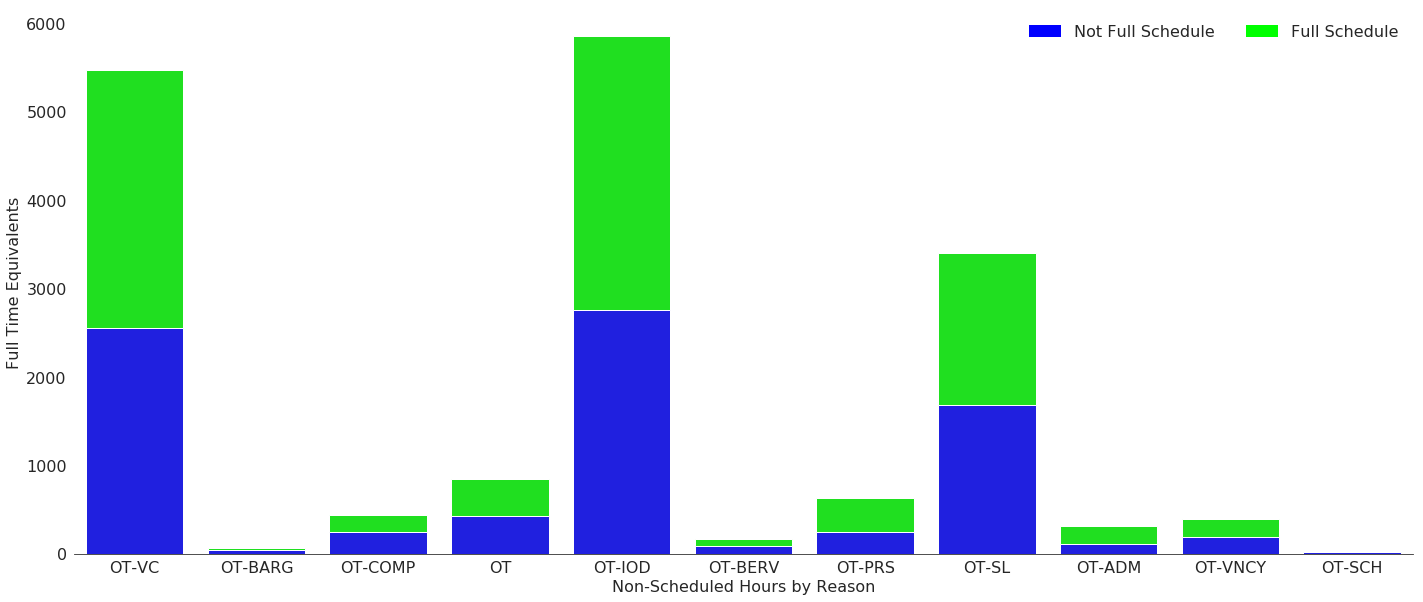

In [54]:
ot_type = {}
ot_hours = {}
ot_reduced = {}

for ffshift in cycle_totals.keys():
    st = cycle_totals[ffshift]
    for typ in st.keys():
        if (('OT-' in typ) | (typ == 'OT')):
            if (typ != 'OT-EOD'):
                if (typ not in ot_type.keys()): 
                    ot_type[typ] = typ
                    ot_hours[typ] = 0.0
                    ot_reduced[typ] = 0.0
                else:
                    hrs = cycle_totals[ffshift][typ]
                    ot_hours[typ] += hrs
                    try:
                        if (st['scheduled'] >= 48.0): ot_reduced[typ] += hrs
                    except KeyError:
                        ;
print('ot_type')        
print(ot_type)
print('ot_hours')
print(ot_hours)
print('ot_reduced')
print(ot_reduced)

xlab = []
ybot = []
ytop = []

for typ in ot_type.keys():
    xlab.append(typ)
    ybot.append(ot_reduced[typ])
    ytop.append(ot_hours[typ])

#Set general plot properties
sns.set_style("white")
sns.set_context({"figure.figsize": (24, 10)})

#Plot 1 - background - "total" (top) series
sns.barplot(x = xlab, y = ytop, color = "#00FF00")

#Plot 2 - overlay - "bottom" series
bottom_plot = sns.barplot(x = xlab, y = ybot, color = "#0000FF")


topbar = plt.Rectangle((0,0),1,1,fc="#00FF00", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#0000FF',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Not Full Schedule', 'Full Schedule'], loc=1, ncol = 2, prop={'size':16})
l.draw_frame(False)

#Optional code - Make plot look nicer
sns.despine(left=True)
bottom_plot.set_ylabel("Full Time Equivalents")
bottom_plot.set_xlabel("Non-Scheduled Hours by Reason")

#Set fonts to consistent 16pt size
for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
             bottom_plot.get_xticklabels() + bottom_plot.get_yticklabels()):
    item.set_fontsize(16)

In [73]:
lt48   = 0
cycles = 0

for key in cycle_totals.keys():
    cycles+=1
    if (cycle_totals[key]['scheduled'] < 48.0): lt48+=1
        
print(cycles)
print(lt48)

1575
965


['0.0', '10.0', '14.0', '20.0', '24.0', '28.0', '34.0', '38.0', '48.0']
[219.0, 249.5, 229.5, 507.0, 1092.0, 480.0, 3735.25, 2797.0, 8429.5]
14961.75
17738.75
3321
4972


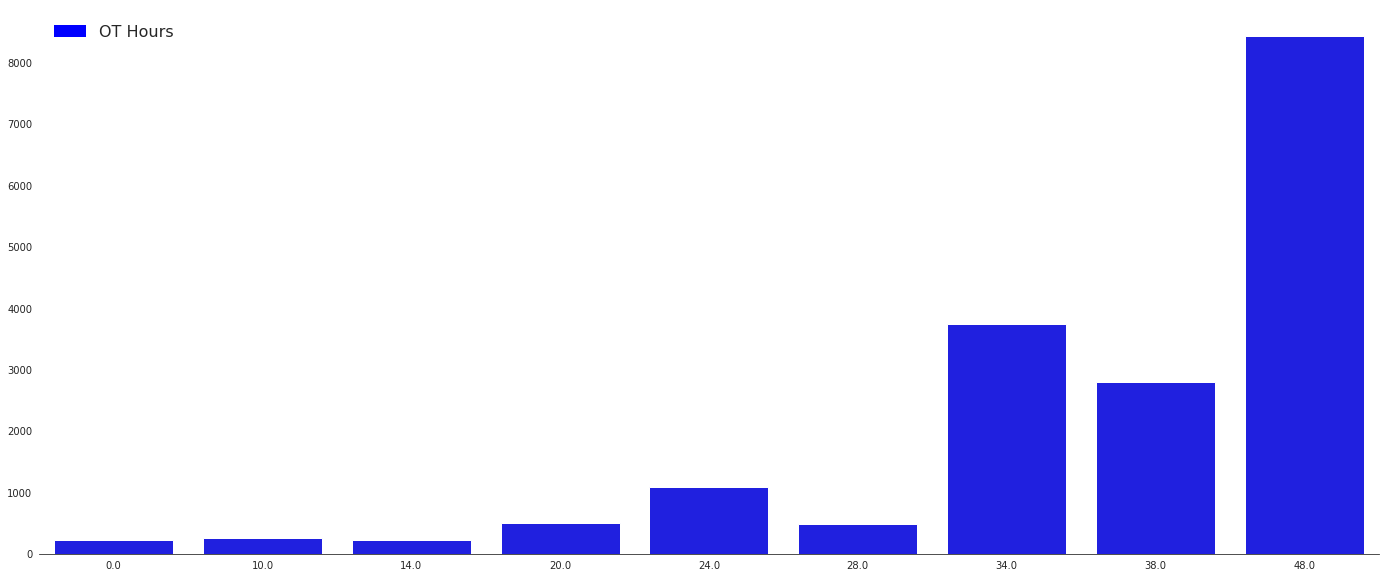

In [66]:
ot_hours = {}

hrs_0_1 = 0.0
hrs_tot   = 0.0
lt_full = 0
cycles = 0

for ffshift in cycle_totals.keys():
    st = cycle_totals[ffshift]
    for typ in st.keys():
        cycles += 1
        rh = st['scheduled']
        if (rh < 47.9): lt_full+=1
        if (rh not in ot_hours.keys()):
            ot_hours[rh] = 0.0
        if (('OT-' in typ) | (typ == 'OT')):
            if (typ != 'OT-EOD'):
                ot_hours[rh] += st[typ]    
                if (rh > 33.0): hrs_0_1 += st[typ]
                hrs_tot += st[typ]

x_labels = []
y_values = []

rh = 0.0
while (rh < 48.5):
    try:
        y_values.append(ot_hours[rh])
        x_labels.append(str(rh))
    except KeyError:
        ;
    rh += 1.0
    

print(x_labels)

print(y_values)

print(hrs_0_1)
print(hrs_tot)
print(lt_full)
print(cycles)

#Set general plot properties
sns.set_style("white")
sns.set_context({"figure.figsize": (24, 10)})

#Plot 1 - background - "total" (top) series
sns.barplot(x = x_labels, y = y_values, color = "#0000FF")

topbar = plt.Rectangle((0,0),1,1,fc="#00FF00", edgecolor = 'none')

l = plt.legend([bottombar, topbar], ['OT Hours'], loc=2, ncol = 2, prop={'size':16})
l.draw_frame(False)

#Optional code - Make plot look nicer
sns.despine(left=True)
bottom_plot.set_ylabel("Full Time Equivalents")
bottom_plot.set_xlabel("Non-Scheduled Hours by Reason")

#Set fonts to consistent 16pt size
for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
             bottom_plot.get_xticklabels() + bottom_plot.get_yticklabels()):
    item.set_fontsize(16)

ot_type
{'OT-VC': 'OT-VC', 'OT-BARG': 'OT-BARG', 'OT-COMP': 'OT-COMP', 'OT': 'OT', 'OT-IOD': 'OT-IOD', 'OT-BERV': 'OT-BERV', 'OT-PRS': 'OT-PRS', 'OT-SL': 'OT-SL', 'OT-ADM': 'OT-ADM', 'OT-VNCY': 'OT-VNCY', 'OT-SCH': 'OT-SCH'}
ot_hours
{'OT-VC': 5529.0, 'OT-BARG': 60.0, 'OT-COMP': 434.0, 'OT': 848.0, 'OT-IOD': 5881.75, 'OT-BERV': 170.0, 'OT-PRS': 644.0, 'OT-SL': 3406.5, 'OT-ADM': 347.0, 'OT-VNCY': 389.0, 'OT-SCH': 16.0}
ot_reduced
{'OT-VC': 2604.0, 'OT-BARG': 41.0, 'OT-COMP': 246.0, 'OT': 429.5, 'OT-IOD': 2767.5, 'OT-BERV': 86.0, 'OT-PRS': 256.0, 'OT-SL': 1684.5, 'OT-ADM': 140.0, 'OT-VNCY': 193.0, 'OT-SCH': 16.0}


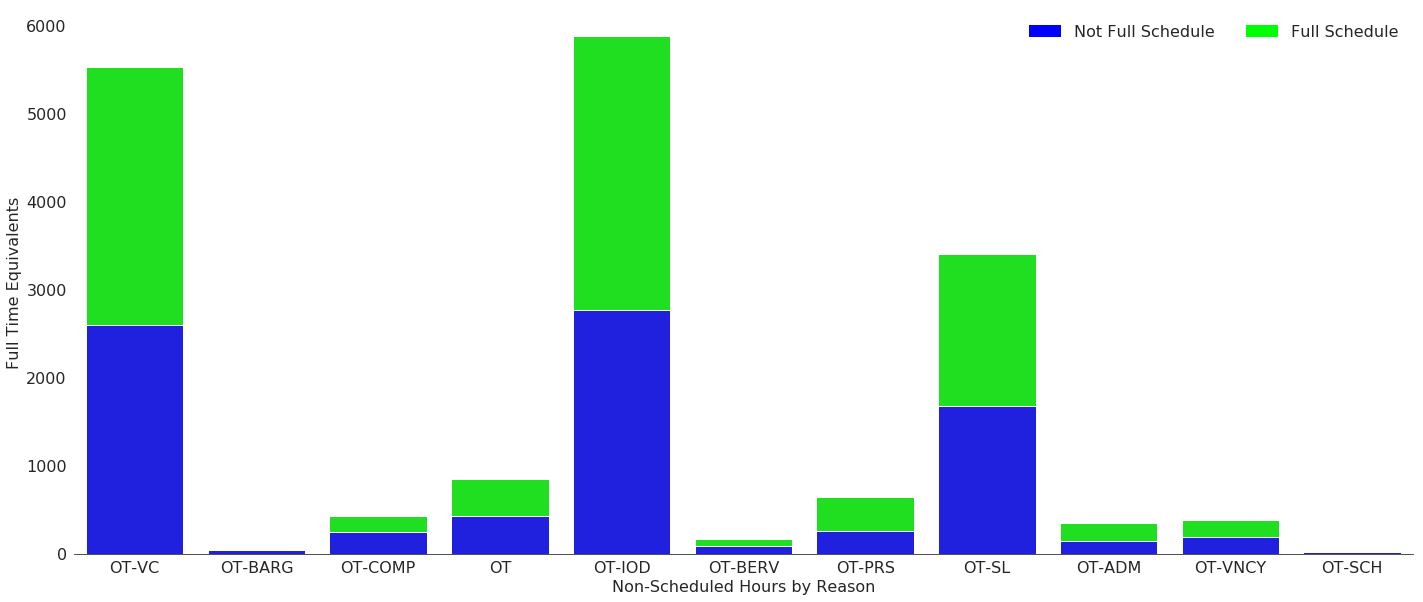

In [364]:
ot_hours = {}

for ffshift in cycle_totals.keys():
    st = cycle_totals[ffshift]
    for typ in st.keys():
        if (('OT-' in typ) | (typ == 'OT')):
            if (typ != 'OT-EOD'):
                hrs = st['hours']
                rh = st['scheduled']
                if (rh not in ot_hours.keys()):
                    ot_hours[rh] = hrs
                else:
                    ot_hours[rh] += hrs

print('ot_type')        
print(ot_type)
print('ot_hours')
print(ot_hours)
print('ot_reduced')
print(ot_reduced)

xlab = []
ybot = []
ytop = []

for typ in ot_type.keys():
    xlab.append(typ)
    ybot.append(ot_reduced[typ])
    ytop.append(ot_hours[typ])

#Set general plot properties
sns.set_style("white")
sns.set_context({"figure.figsize": (24, 10)})

#Plot 1 - background - "total" (top) series
sns.barplot(x = xlab, y = ytop, color = "#00FF00")

#Plot 2 - overlay - "bottom" series
bottom_plot = sns.barplot(x = xlab, y = ybot, color = "#0000FF")


topbar = plt.Rectangle((0,0),1,1,fc="#00FF00", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#0000FF',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Not Full Schedule', 'Full Schedule'], loc=1, ncol = 2, prop={'size':16})
l.draw_frame(False)

#Optional code - Make plot look nicer
sns.despine(left=True)
bottom_plot.set_ylabel("Full Time Equivalents")
bottom_plot.set_xlabel("Non-Scheduled Hours by Reason")

#Set fonts to consistent 16pt size
for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
             bottom_plot.get_xticklabels() + bottom_plot.get_yticklabels()):
    item.set_fontsize(16)